In [2]:
# Load results method 
# def get_expected_alignment_curve(database_utms: np.ndarray, query_utms: np.ndarray) -> np.ndarray:
#     """
#     Compute expected reference (database) indices for each query index
#     based on VO-derived UTM positions.
#     """
#     from scipy.interpolate import interp1d

#     def compute_speeds(utms: np.ndarray) -> np.ndarray:
#         diffs = np.diff(utms, axis=0)
#         dists = np.linalg.norm(diffs, axis=1)
#         speeds = np.insert(dists, 0, 0)
#         return speeds

#     # Compute cumulative normalized distance along both trajectories
#     speeds_db = compute_speeds(database_utms)
#     speeds_q = compute_speeds(query_utms)

#     cum_dist_db = np.cumsum(speeds_db)
#     cum_dist_q = np.cumsum(speeds_q)

#     norm_dist_db = cum_dist_db / cum_dist_db[-1]
#     norm_dist_q = cum_dist_q / cum_dist_q[-1]

#     # Interpolate reference index from normalized query progress
#     interp_fn = interp1d(norm_dist_db, np.arange(len(norm_dist_db)), kind='linear', fill_value='extrapolate')
#     expected_ref_indices = interp_fn(norm_dist_q)

#     return expected_ref_indices

#     # expected_query_indices = get_expected_alignment_curve(test_ds.database_utms, test_ds.queries_utms)
#     # max_q_idx = int(np.ceil(expected_query_indices.max()))
#     # alignment_matrix = np.zeros((len(expected_query_indices), max_q_idx + 1))
#     # for db_idx, expected_q_idx in enumerate(expected_query_indices):
#     #     q_idx = int(np.round(expected_q_idx))
#     #     if 0 <= q_idx < alignment_matrix.shape[0]:
#     #         alignment_matrix[db_idx, q_idx] = 1

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def load_results(dataset_type):
    df_list = []
    time_res_list = [0.1, 0.2, 0.25, 0.5, 1.0] 
    count_bins_list = [100_000, 200_000, 300_000, 500_000, 1_000_000]

    # Load time-bin results
    for time in time_res_list:
        path = f'./results/vpr_results_{dataset_type}_fixed_timebins_{time}.csv'
        try:
            df_temp = pd.read_csv(path)
            df_temp['time_res'] = f'time_{time}'
            if not df_temp.empty:
                df_list.append(df_temp)
        except FileNotFoundError:
            print(f"File {path} not found.")

    # Load count-bin results
    for count in count_bins_list:
        path = f'./results/vpr_results_{dataset_type}_fixed_countbins_{count}.csv'
        try:
            df_temp = pd.read_csv(path)
            df_temp['time_res'] = df_temp['time_res'].fillna(f'count_{count}')
            if not df_temp.empty:
                df_list.append(df_temp)
        except FileNotFoundError:
            print(f"File {path} not found.")
            continue

    # Concatenate all
    if not df_list:
        return pd.DataFrame()  # Return empty if nothing was loaded

    df = pd.concat(df_list, ignore_index=True)

    # Drop duplicates excluding 'runtime'
    cols_ex_runtime = [col for col in df.columns if col != 'runtime']
    df = df.drop_duplicates(subset=cols_ex_runtime)

    return df

# Matplotlib settings for LaTeX-like appearance
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Computer Modern'],
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'legend.title_fontsize': 10,
    'lines.linewidth': 1.0,         # Default line width
    'lines.markersize': 0.5,        # Default marker size
    'lines.markeredgewidth': 0.5,  # Default marker edge width
    'text.usetex': False
})

sns.set_theme(style="whitegrid", font_scale=0.7)
rename_map = {
    'R0_FA0': 'FA0',
    'R0_FN0': 'FN0',
    'R0_FS0': 'FS0',
    'R0_RA0': 'RA0',
    'R0_RN0': 'RN0',
    'R0_RS0': 'RS0',
}



In [ ]:
# Comaparison of count and time bins - plot abd print displacement table
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import colors as mcolors
from matplotlib.cm import ScalarMappable
from typing import Union, List

def plot_performance_vs_compute_side_by_side(df1, df2, group_feature='time_res', mode='frame', ds1='Brisbane', ds2='NSAVP'):
    assert mode in ['patch', 'frame'], "mode must be 'patch' or 'frame'"

    def prepare_data(df):
        grouped = df.groupby([group_feature, 'patch_or_frame']).agg({
            'recall_at_1': ['mean', 'count'],
            'num_ref_frames': 'mean',
            'num_qry_frames': 'mean'
        }).reset_index()

        # Flatten MultiIndex column names
        grouped.columns = ['group', 'patch_or_frame', 'recall_at_1', 'count', 'num_ref_frames', 'num_qry_frames']

        grouped['compute_cost'] = grouped['num_ref_frames'] + grouped['num_qry_frames']

        def categorize(x):
            if str(x).startswith('count_'):
                return 'count'
            elif str(x).startswith('time_'):
                return 'time'
            else:
                return 'other'

        grouped['category'] = grouped['group'].apply(categorize)
        grouped = grouped[(grouped['patch_or_frame'] == mode) & grouped['category'].isin(['count', 'time'])]
        grouped['bin_value'] = grouped['group'].str.extract(r'_(\d+\.?\d*)')[0].astype(float)
        grouped = grouped.sort_values(by=['category', 'compute_cost'])
        return grouped


    grouped1 = prepare_data(df1)
    grouped2 = prepare_data(df2)

    # Normalize for color mapping
    norm_count = mcolors.Normalize(vmin=grouped1[grouped1['category'] == 'count']['bin_value'].min(),
                                   vmax=grouped1[grouped1['category'] == 'count']['bin_value'].max())
    norm_time = mcolors.Normalize(vmin=grouped1[grouped1['category'] == 'time']['bin_value'].min(),
                                  vmax=grouped1[grouped1['category'] == 'time']['bin_value'].max())
    cmap_count = sns.light_palette("blue", as_cmap=True)
    cmap_time = sns.light_palette("green", as_cmap=True)
    marker_map = {'count': 'o', 'time': '^'}

    fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

    for ax, grouped, title in zip(axs, [grouped1, grouped2], [ds1, ds2]):
        for category in ['count', 'time']:
            cat_data = grouped[grouped['category'] == category]
            norm = norm_count if category == 'count' else norm_time
            cmap = cmap_count if category == 'count' else cmap_time
            marker = marker_map[category]

            # Plot lines and points
            ax.plot(cat_data['compute_cost'], cat_data['recall_at_1'], color='gray', linestyle='-', zorder=1)
            for _, row in cat_data.iterrows():
                color = cmap(norm(row['bin_value']))
                ax.plot(row['compute_cost'], row['recall_at_1'],
                        marker=marker, color='gray',
                        markerfacecolor=color, zorder=2)

                # Print count info
                # print(f"{title} | {category} bin={row['bin_value']} → Recall@1={row['recall_at_1']:.4f} from {int(row['count'])} runs")
#

        ax.set_title(f"{title}")
        ax.set_xlabel("Sum of Reference and Query Frames")
        # ax.tick_params(labelsize=12)

    axs[0].set_ylabel("Mean Recall@1")

    # Colorbars
    cbar_ax1 = fig.add_axes([0.92, 0.55, 0.015, 0.3])
    cbar_ax2 = fig.add_axes([0.92, 0.15, 0.015, 0.3])
    sm_count = ScalarMappable(norm=norm_count, cmap=cmap_count)
    sm_time = ScalarMappable(norm=norm_time, cmap=cmap_time)
    sm_count.set_array([])
    sm_time.set_array([])
    fig.colorbar(sm_count, cax=cbar_ax1).set_label("Count Bin Size")
    fig.colorbar(sm_time, cax=cbar_ax2).set_label("Time Bin Size")

    # plt.suptitle("Performance vs Compute Cost Across Bin Sizes",)
    plt.tight_layout(rect=[0, 0, 0.9, 1.02])
    plt.savefig('./plots/0_performance_across_bintypes_and_binsize.pdf', bbox_inches='tight')



def print_compact_displacement_table(csv_path: str):
    """
    Prints a LaTeX table with:
    - Two blocks: one for count bins, one for time bins
    - Custom headers and horizontal lines
    - Formatted as \resizebox{\columnwidth}{!}{...}
    """
    df = pd.read_csv(csv_path)

    # Filter out count_1e6 if present
    df = df[~((df['binning_type'] == 'time') & (df['binning_value'] == 0.15))]

    # Aggregate mean ± std
    agg = df.groupby(['binning_type', 'dataset', 'binning_value'])['mean_displacement'].agg(['mean', 'std']).reset_index()
    agg['formatted'] = agg.apply(lambda r: f"{r['mean']:.2f} ± {r['std']:.2f}", axis=1)

    def format_block(binning_type, label):
        subset = agg[agg['binning_type'] == binning_type]
        bins = sorted(subset['binning_value'].unique())

        # Header row
        header = f" {label} & " + " & ".join([str(int(b)) if binning_type == 'count' else str(b) for b in bins]) + " \\\\"
        
        # Data rows
        def format_row(dataset):
            row = subset[subset['dataset'] == dataset]
            vals = []
            for b in bins:
                entry = row[row['binning_value'] == b]
                vals.append(entry['formatted'].values[0] if not entry.empty else "–")
            return f" {dataset} & " + " & ".join(vals) + " \\\\"

        brisbane = format_row("Brisbane")
        nsavp = format_row("NSAVP")
        return [header, "\\hline", brisbane, nsavp, "\\hline", "\\\\"]

    count_block = format_block("count", "Events per Bin")
    time_block = format_block("time", "Duration per Bin")

    # Assemble full LaTeX table
    latex = ["\\resizebox{\\columnwidth}{!}{%", "\\begin{tabular}{lllllll}", "\\centering"]
    latex += count_block + time_block
    latex += ["\\end{tabular}", "}"]

    print("\n".join(latex))






df1 = load_results('Brisbane')
df1 = df1[(df1['vpr_method'] != 'anyloc-urban') & (df1['seq_len'] == 1) & (df1['binning_strategy'] == 'fixed') ]

df2 = load_results('NSAVP')
df2 = df2[(df2['vpr_method'] != 'anyloc-urban') & (df2['seq_len'] == 1) & (df2['binning_strategy'] == 'fixed') ]

displacement_csv = './hpc/displacement_per_traverse1.csv'

plot_performance_vs_compute_side_by_side(df1, df2, group_feature='time_res', mode='frame')
print_compact_displacement_table(displacement_csv)


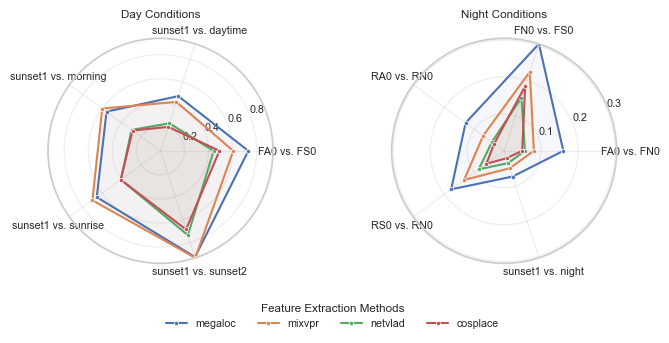

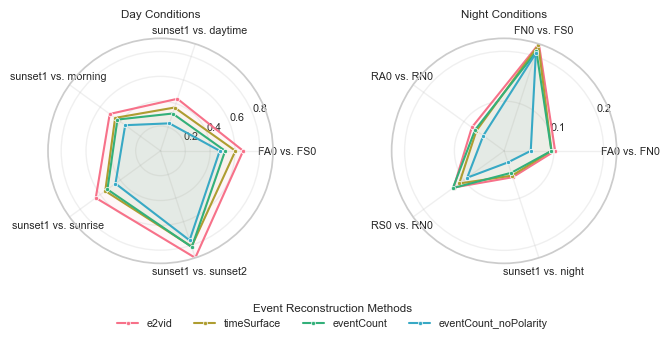

In [4]:
# Radar plot frame based results with no seq matching for VPR methods and reconstruction methods
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import matplotlib.patches as mpatches

sns.set_theme(style="whitegrid", font_scale=0.7)

def radar_plot_vpr_publication(df, group_feature='vpr_method', cPallete='muted'):
    """Publication-quality radar plot for VPR methods with separate rows for each sequence length"""
    
    df = df.copy()
    
    df['ref_seq'] = df['ref_seq'].map(rename_map).fillna(df['ref_seq'])
    df['qry_seq'] = df['qry_seq'].map(rename_map).fillna(df['qry_seq'])
    df['pair'] = df['ref_seq'] + " vs. " + df['qry_seq']
    
    # Get unique sequence lengths and sort them
    seq_lengths = sorted(df['seq_len'].unique())
    n_seq_lengths = len(seq_lengths)
    
    # Create subplots: rows for seq_len, columns for day/night
    fig, axs = plt.subplots(n_seq_lengths, 2, figsize=(7, 3* n_seq_lengths), 
                           subplot_kw=dict(polar=True))
    
    # Handle case where there's only one sequence length
    if n_seq_lengths == 1:
        axs = axs.reshape(1, -1)
    
    fig.subplots_adjust(bottom=0.1, top=0.85, left=0.05, right=0.95, hspace=0.3)
    
    # Use seaborn color palette for VPR methods
    vpr_colors = sns.color_palette(cPallete, 5)
    all_handles = []
    label_names = []
    
    for row_idx, seq_len in enumerate(seq_lengths):
        # Filter data for current sequence length
        df_seq = df[df['seq_len'] == seq_len]
        # Filter for night and day sequences
        df_night = df_seq[df_seq['pair'].str.contains("night|N0", case=False, na=False)]
        df_day = df_seq[~df_seq['pair'].str.contains("night|N0", case=False, na=False)]
        
        for col_idx, (subset, title_suffix) in enumerate(zip([df_day, df_night], 
                                                            ['Day Conditions', 'Night Conditions'])):
            ax = axs[row_idx, col_idx]
            grouped = subset.groupby([group_feature, 'pair'])['recall_at_1'].mean().unstack(fill_value=0)
            if grouped.empty:
                ax.text(0.5, 0.5, 'No Data Available', transform=ax.transAxes, 
                       ha='center', va='center', style='italic')
                ax.set_title(title)
                ax.grid(False)
                ax.set_xticks([])
                ax.set_yticks([])
                continue
            
            # Sort by mean performance
            # print(grouped.count())
            mean_scores = grouped.mean(axis=1)
            grouped = grouped.loc[mean_scores.sort_values(ascending=False).index]
            color_map = dict(zip(grouped.index, vpr_colors[:len(grouped)]))
            
            pair_labels = grouped.columns.tolist()
            angles = np.linspace(0, 2 * np.pi, len(pair_labels), endpoint=False).tolist()
            angles += angles[:1]
            
            for method in grouped.index:
                values = grouped.loc[method].tolist() + [grouped.loc[method].tolist()[0]]
                color = color_map[method]
                
                line, = ax.plot(angles, values, label=method, color=color, marker='.',
                               markerfacecolor=color, markeredgecolor='white')
                ax.fill(angles, values, alpha=0.05, color=color)
                
                # Collect handles from first plot only (top-left)
                if row_idx == 0 and col_idx == 0:
                    all_handles.append(line)
                    label_names.append(method)
            title = f'{title_suffix}'
            # Customize axes
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels(pair_labels)
            ax.tick_params(axis='x', pad=-3)
            ax.grid(True, alpha=0.3)
            
            max_recall = grouped.max().max()
            upper_lim = max_recall
            if max_recall < 0.5:
                ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
                ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])
            else: 
                ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
                ax.set_yticklabels([ '0.2', '0.4', '0.6',  '0.8', '1.0'])
            ax.set_ylim(0, upper_lim)
            ax.set_title(title)
    
    # Single legend below all plots
    if group_feature == 'reconstruction_name':
        legend_title = 'Event Reconstruction Methods'
    else:   
        legend_title = 'Feature Extraction Methods'
    fig.legend(all_handles, label_names, loc='lower center', 
              bbox_to_anchor=(0.5, -0.15), ncol=4, 
              frameon=False, title=legend_title)
    
    type_name = 'Event Reconstruction Method' if group_feature == 'reconstruction_name' else 'VPR Method'
    # plt.suptitle(f"Recall@1 {type_name}\nunder Varied Illumination Conditions and Sequence Lengths", y=1.02)
    
    # Save high-quality outputs
    save_path = f'./plots/0_performance_across_{group_feature}_by_seqlen.pdf'
    plt.savefig(save_path, format='pdf', bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    

# Example usage (uncomment when you have your data):
df = pd.concat([load_results('Brisbane'), load_results('NSAVP')], ignore_index=True)
df = df[df['vpr_method'] != 'anyloc-urban']  
# df = df[df['vpr_method'] == 'mixvpr']  # Use 'mixvpr' for VPR-only plot
df = df[(df['seq_len'] == 1)]
df = df[df['bin_type'] == 'timebin']
df = df[df['patch_or_frame']== 'frame']
# df = df[df['patch_rows'] == 2]
# df = df[df['time_res'] == 'time_1.0']  # Use fixed time bin size
df = df[df['reconstruction_name'] != 'RGB_camera']


# For VPR-only plot:
radar_plot_vpr_publication(df, group_feature='vpr_method',  cPallete='deep')
radar_plot_vpr_publication(df, group_feature='reconstruction_name', cPallete='husl')

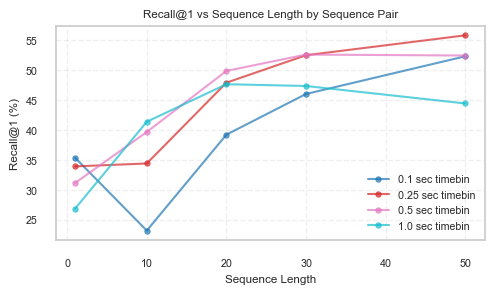

\begin{table}[ht]
\centering
\begin{tabular}{lcccc}
\toprule
Time Resolution & SeqLen 10 & SeqLen 20 & SeqLen 30 & SeqLen 50 \\
\midrule
time_0.1 & -12.16 & 3.87 & 10.66 & 16.96 \\
time_0.25 & 0.48 & 13.98 & 18.57 & 21.89 \\
time_0.5 & 8.52 & 18.73 & 21.46 & 21.30 \\
time_1.0 & 14.52 & 20.79 & 20.49 & 17.57 \\
\bottomrule
\end{tabular}
\caption{Mean Recall@1 improvement over SeqLen=1 for each time resolution.}
\label{tab:seqmatch_improvement_timeres}
\end{table}


In [ ]:
#Sequence match table and scatter plot
def plot_recall_scatter(df):
    """Option 4: Scatter Plot - Shows relationship between sequence length and recall"""
    
    # Same preprocessing
    df['ref_seq_renamed'] = df['ref_seq'].map(rename_map).fillna(df['ref_seq'])
    df['qry_seq_renamed'] = df['qry_seq'].map(rename_map).fillna(df['qry_seq'])
    df = df[df['patch_or_frame'] == 'frame']
    
    grouped = (
        df.groupby(['time_res', 'seq_len'])
        .agg(recall_at_1_mean=('recall_at_1', 'mean'))
        .reset_index()
    )
    grouped['pair_label'] = grouped['time_res'].str.split('_').str[-1] + ' sec timebin'  # grouped['pair_label'] = grouped['ref_seq_renamed'] + ' → ' + grouped['qry_seq_renamed']
    grouped['recall_percent'] = grouped['recall_at_1_mean'] * 100
    
    plt.figure(figsize=(5, 3))
    
    pairs = grouped['pair_label'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(pairs)))
    
    for i, pair in enumerate(pairs):
        data = grouped[grouped['pair_label'] == pair]
        plt.plot(data['seq_len'], data['recall_percent'], 
                 label=pair, color=colors[i], marker='o', markersize=4, 
                 linewidth=1.5, alpha=0.7)
        
    
    plt.xlabel('Sequence Length')
    plt.ylabel('Recall@1 (%)')
    plt.title('Recall@1 vs Sequence Length by Sequence Pair')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig("./plots/recall_scatter.pdf", format='pdf', bbox_inches='tight')
    plt.show()

def generate_seqmatch_improvement_table_with_timeres(df):
    import pandas as pd

    # Rename sequences and create pair labels
    df['ref_seq_renamed'] = df['ref_seq'].map(rename_map).fillna(df['ref_seq'])
    df['qry_seq_renamed'] = df['qry_seq'].map(rename_map).fillna(df['qry_seq'])
    df['pair_label'] = df['ref_seq_renamed'] + ' → ' + df['qry_seq_renamed']

    # Filter to frame-based and timebin-type only
    df = df[(df['patch_or_frame'] == 'frame') & (df['bin_type'] == 'timebin')]

    # Group by pair, time resolution, and sequence length
    grouped = (
        df.groupby(['pair_label', 'time_res', 'seq_len'])
        .agg(recall=('recall_at_1', 'mean'))
        .reset_index()
    )

    # Pivot to wide format: rows=(pair_label, time_res), columns=seq_len
    pivot = grouped.pivot(index=['pair_label', 'time_res'], columns='seq_len', values='recall') * 100

    # Ensure baseline exists
    if 1 not in pivot.columns:
        raise ValueError("Sequence length 1 is required for baseline comparison.")

    # Subtract baseline (seq_len = 1)
    improvements = pivot.subtract(pivot[1], axis=0).drop(columns=[1])

    # Mean improvement across sequence pairs, grouped by time_res
    mean_improvements = improvements.groupby(level='time_res').mean().round(2)

    # Generate LaTeX table
    latex = "\\begin{table}[ht]\n\\centering\n"
    latex += "\\begin{tabular}{l" + "c" * len(mean_improvements.columns) + "}\n"
    latex += "\\toprule\n"
    latex += "Time Resolution & " + " & ".join([f"SeqLen {int(c)}" for c in mean_improvements.columns]) + " \\\\\n"
    latex += "\\midrule\n"

    for time_res in mean_improvements.index:
        row_vals = " & ".join([f"{mean:.2f}" for mean in mean_improvements.loc[time_res]])
        latex += f"{time_res} & {row_vals} \\\\\n"

    latex += "\\bottomrule\n"
    latex += "\\end{tabular}\n"
    latex += "\\caption{Mean Recall@1 improvement over SeqLen=1 for each time resolution.}\n"
    latex += "\\label{tab:seqmatch_improvement_timeres}\n"
    latex += "\\end{table}"

    print(latex)


# Usage example:
df = pd.concat([load_results('Brisbane'), load_results('NSAVP')], ignore_index=True)
df = df[df['vpr_method'] != 'anyloc-urban']  
df = df[(df['seq_len'].isin([1, 10, 20, 30, 50]))]
df = df[df['bin_type'] == 'timebin']
df = df[df['time_res'] != 'time_0.2']  # Use a specific time bin for clarity
df = df[df['patch_or_frame'] == 'frame']
df = df[df['reconstruction_name'] != 'RGB_camera']

# Choose one or more visualization methods:
plot_recall_scatter(df)        # Best for sequence length relationships
generate_seqmatch_improvement_table_with_timeres(df)

patch_cols   1   2   3   4   5   6   7   8   9
patch_rows                                    
1           20  20  20  20  20  20  20  20  20
2           20  20  20  20  20  20  20  20  20
3           20  20  20  20  20  20  20  20  20
4           20  20  20  20  20  20  20  20  20
5           20  20  20  20  20  20  20  20  20
6           20  20  20  20  20  20  20  20  20
7           20  20  20  20  20  20  20  20  20
8           20  20  20  20  20  20  20  20  20
9           20  20  20  20  20  20  20  20  20


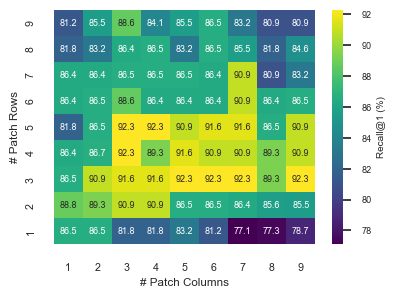

In [110]:
# Grid Search Heatmap and sequence length analysis
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from typing import Union, List
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML

# Load the CSV file
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def patches_grid_search_heatmap():
    """
    Generates a heatmap from grid search results stored in a CSV file.
    The heatmap visualizes the recall at 1 for different patch grid sizes.
    """
    # Load the CSV file
    csv_path = "./hpc/patch_grid_search_results1.csv"
    df = pd.read_csv(csv_path)
    df = df[df["vpr_method"] == "mixvpr"]
    # df = df[df["reconstruction_name"] !="e2vid"]
    # Drop duplicates based on all columns except 'runtime'
    df = df.drop_duplicates(subset=[col for col in df.columns if col != "runtime"])

    # Convert recall to percentage
    df["recall_at_1"] = df["recall_at_1"] * 100
    # Create grid
    grid_df = df.pivot_table(
        index="patch_rows",
        columns="patch_cols",
        values="recall_at_1",
        aggfunc="median"
    )
    count_grid = df.pivot_table(
        index="patch_rows",
        columns="patch_cols",
        values="recall_at_1",
        aggfunc="count"
    )
    print(count_grid)
    # Shared color scale
    vmin, vmax = grid_df.min().min(), grid_df.max().max()

    # Determine figure size based on grid size
    n_rows, n_cols = grid_df.shape


    fig, ax = plt.subplots(figsize=(4, 3))
    sns.set_theme(style="whitegrid", font_scale=0.6)
    # Plot heatmap
    heatmap = sns.heatmap(
        grid_df, annot=True, fmt=".1f", cmap="viridis",
        vmin=vmin, vmax=vmax, ax=ax, annot_kws={'fontsize':6.5}, 
        cbar_kws={"label": "Recall@1 (%)"}
    )

    # Labels and titles
    # ax.set_title("Recall@1 by Patch Grid Size")
    ax.set_xlabel("# Patch Columns")
    ax.set_ylabel("# Patch Rows")
    ax.invert_yaxis()

    # Save plot
    plt.tight_layout()
    plt.savefig('./plots/0_patch_grid_search_results.pdf', bbox_inches='tight')


def plot_grouped_bar_by_seq_len_and_patch_type(df):
    # Apply renaming to ref_seq and qry_seq
    df['ref_seq_renamed'] = df['ref_seq'].map(rename_map).fillna(df['ref_seq'])
    df['qry_seq_renamed'] = df['qry_seq'].map(rename_map).fillna(df['qry_seq'])

    # Group and compute both count and mean
    grouped = (
        df.groupby(['ref_seq_renamed', 'qry_seq_renamed', 'seq_len', 'patch_or_frame'])
        .agg(
            recall_at_1_mean=('recall_at_1', 'mean'),
            experiment_count=('recall_at_1', 'count')
        )
        .reset_index()
    )

    # Add descriptive pair label
    grouped['pair_label'] = grouped['ref_seq_renamed'] + ' → ' + grouped['qry_seq_renamed']


    expected = 96  # or whatever is the nominal count
    grouped_debug = df[df['ref_seq'].str.startswith("sunset1")].groupby(
        ['ref_seq', 'qry_seq', 'seq_len', 'patch_or_frame']
    )['recall_at_1'].count()

    print("🔍 Brisbane combinations with missing or extra runs:")
    print(grouped_debug[grouped_debug != expected])

    # Unique identifiers
    sequence_pairs = grouped['pair_label'].unique()
    seq_lens = sorted(grouped['seq_len'].unique())
    patch_types = ['frame', 'patch']

    # Color setup
    cl=0
    base_colors = sns.color_palette("deep", len(seq_lens)+cl)
    color_map = {}
    for i, seq_len in enumerate(seq_lens):
        base = base_colors[i+cl]
        color_map[(seq_len, 'patch')] = base
        color_map[(seq_len, 'frame')] = tuple(min(1.0, c + 0.3) for c in base)

    # Bar plotting
    # Separate day vs night pairs
    grouped['is_night'] = grouped['pair_label'].str.contains("night|N0", case=False, na=False)
    day_grouped = grouped[~grouped['is_night']]
    night_grouped = grouped[grouped['is_night']]

    # Plotting setup
    fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharey=True)
    bar_width = 0.1
    patch_types = ['frame', 'patch']

    for ax_idx, (subset, title) in enumerate(zip([day_grouped, night_grouped], ["Day Conditions", "Night Conditions"])):
        ax = axs[ax_idx]
        sequence_pairs = subset['pair_label'].unique()

        for i, pair in enumerate(sequence_pairs):
            x_base = i
            offset = -((len(seq_lens) * 2 - 1) * bar_width) / 2

            for j, seq_len in enumerate(seq_lens):
                for k, patch_type in enumerate(patch_types):
                    
                    row = subset[
                        (subset['pair_label'] == pair) &
                        (subset['seq_len'] == seq_len) &
                        (subset['patch_or_frame'] == patch_type)
                    ]

                    if not row.empty:
                        if patch_type == 'frame':
                            legend_label = f'Frame based - seqlen {seq_len}' if i == 0 else None
                        else:
                            legend_label = f'Patch based - seqlen {seq_len}' if i == 0 else None
                        recall = row['recall_at_1_mean'].values[0] * 100
                        color = color_map[(seq_len, patch_type)]
                        x = x_base + offset + (j * 2 + k) * bar_width
                        ax.bar(x, recall, width=bar_width, color=color, label=legend_label, alpha=0.8)
                        if recall <15:
                            ax.text(x, recall + 10, f"{recall:.1f}", ha='center', va='top', fontsize=7, rotation=90)
                        else:
                            ax.text(x, recall + 0.3, f"{recall:.1f}", ha='center', va='top', fontsize=7, rotation=90)

        ax.set_xticks(range(len(sequence_pairs)))
        ax.set_xticklabels(sequence_pairs, rotation=0, ha='center')
        ax.set_title(title)
        if ax_idx == 1:
            ax.set_xlabel("Sequence Pair")
        if ax_idx == 1:
            ax.legend(loc='upper left', ncol=1)
        ax.set_ylabel("Recall@1")
        ax.grid(False)

    plt.tight_layout()
    save_path = f'./plots/0_patch_vs_  frame_by_seqlen.pdf'
    plt.savefig(save_path, format='pdf', bbox_inches='tight', 
                facecolor='white', edgecolor='none')


def plot_grouped_box_by_seq_len_and_patch_type(df):
    # Rename sequences
    df['ref_seq_renamed'] = df['ref_seq'].map(rename_map).fillna(df['ref_seq'])
    df['qry_seq_renamed'] = df['qry_seq'].map(rename_map).fillna(df['qry_seq'])
    df['pair_label'] = df['ref_seq_renamed'] + ' → ' + df['qry_seq_renamed']

    # Add method label for coloring
    df['method_type'] = df['seq_len'].astype(str) + ' (' + df['patch_or_frame'] + ')'
    df['recall_at_1_percent'] = df['recall_at_1'] * 100
    df['is_night'] = df['pair_label'].str.contains("night|N0", case=False, na=False)
    
    # Print selected features
    max_rows = df.loc[df.groupby('pair_label')['recall_at_1_percent'].idxmax()]
    max_rows = max_rows.sort_values(by='recall_at_1_percent', ascending=False)
    print_cols = ['pair_label', 'recall_at_1_percent','vpr_method', 'reconstruction_name', 'time_res', 'method_type']
    print(max_rows[print_cols])
    expected = 96  # or whatever is the nominal count
    grouped_debug = df[df['ref_seq'].str.startswith("sunset1")].groupby(
        ['ref_seq', 'qry_seq', 'seq_len', 'patch_or_frame']
    )['recall_at_1'].count()
    print("🔍 Brisbane combinations with missing or extra runs:")
    print(grouped_debug[grouped_debug != expected])

    # Split into day/night subsets
    day_df = df[~df['is_night']]
    night_df = df[df['is_night']]
    
    # Adjust colors per sequence length and patch type
    seq_lens = sorted(df['seq_len'].unique())
    patch_types = [ 'frame', 'patch',]
    base_colors = sns.color_palette("deep", len(seq_lens))
    color_map = {}
    for i, seq_len in enumerate(seq_lens):
        base = base_colors[i]
        frame_key = f"{seq_len} (frame)"
        patch_key = f"{seq_len} (patch)"
        color_map[patch_key] = base
        color_map[frame_key] = tuple(min(1.0, c + 0.3) for c in base)
    hue_order = [f"{s} ({t})" for s in seq_lens for t in patch_types]

    
    # Plot
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharey=True)
    for ax, subset, title in zip(axs, [day_df, night_df], ['Day Conditions', 'Night Conditions']):
        sns.boxplot(
            data=subset,
            x='pair_label',
            y='recall_at_1_percent',
            hue ='method_type',
            hue_order=hue_order,
            palette=color_map,
            ax=ax,
            linewidth=1.0,
            fliersize=2,
            width=0.7,
        )
        ax.set_title(title)
        ax.set_xlabel("Sequence Pair")
        ax.set_ylabel("Recall@1 (%)")
        ax.tick_params(axis='x', rotation=0)
        ax.legend_.remove()


    # Legend
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, title='Seq Len (Type)', loc='upper center', ncol=3)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    
    save_path = './plots/0_patch_vs_frame_boxplot_by_seqlen.pdf'
    plt.savefig(save_path, format='pdf', bbox_inches='tight')
    plt.show()


patches_grid_search_heatmap()

df = pd.concat([load_results('Brisbane'), load_results('NSAVP')], ignore_index=True)
df = df[df['vpr_method'] != 'anyloc-urban']
# df = df[df['vpr_method'] != 'megaloc']
df = df[df['bin_type'] == 'timebin']
df = df[(df['patch_rows'] != 4)]
df = df[(df['patch_cols']!=3)]
df = df[(df['patch_or_frame'] == 'patch')]
df= df[df['reconstruction_name'] != 'RGB_camera']
# df = df[(df['seq_len'] == 10) | (df['seq_len'] == 1) | (df['seq_len'] == 20) | (df['seq_len'] == 30) | (df['seq_len'] == 50)]



# df =df[df['time_res']=='time_1.0']
# df = df[df['reconstruction_name'] == 'e2vid']
# df = df[df['vpr_method'] == 'megaloc']
# plot_grouped_bar_by_seq_len_and_patch_type(df)
# plot_grouped_box_by_seq_len_and_patch_type(df)
# plot_line_by_seq_len_and_patch_type(df)



In [ ]:
# Comapre Ensemble vs. Best Individual VPR Recall@1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.ticker as mtick

# Load ensemble results
ensemble_df = pd.read_csv('./hpc/ablate_ensemble_combination.csv')
ensemble_df['ref_qry_pair'] = ensemble_df['ref_name'] + ' → ' + ensemble_df['qry_name']
ensemble_df = ensemble_df[ensemble_df['seqLen'].isin([10,20])]
# ensemble_df = ensemble_df[ensemble_df['ensemble_over'] != 'patch']
ensemble_df['ensemble_type'] = ensemble_df['ensemble_over']
ensemble_df = ensemble_df[['ref_qry_pair', 'ensemble_type', 'seqLen', 'recall@1']]
ensemble_df.rename(columns={'seqLen': 'seq_len', 'recall@1': 'ensemble_recall'}, inplace=True)
print(ensemble_df.head())


# Load and filter VPR results
df_base = pd.concat([load_results('Brisbane'), load_results('NSAVP')], ignore_index=True)
df_base = df_base[df_base['seq_len'].isin([10,20])]
df_base = df_base[df_base['time_res'] == 'time_1.0']
df_base = df_base[df_base['patch_or_frame'] == 'frame']
df_base = df_base[df_base['reconstruction_name'] != 'RGB_camera']
df_base = df_base[df_base['vpr_method'] != 'anyloc-urban']
df_base['ref_qry_pair'] = df_base['ref_seq'] + ' → ' + df_base['qry_seq']
df_base['ensemble_type'] = 'Baseline'
print(df_base.head())

# count samples for each ref_qry_pair and ensemble_type
df_base['ensemble_type'] = 'Baseline'
baseline_count = df_base.groupby(['ref_qry_pair', 'ensemble_type']).size().reset_index(name='count')
ensemble_count = ensemble_df.groupby(['ref_qry_pair', 'ensemble_type']).size().reset_index(name='count')
count_df = pd.concat([baseline_count, ensemble_count], ignore_index=True)
print("✅ Counts of each ref_qry_pair and ensemble_type:")
print(count_df.sort_values(['ref_qry_pair', 'ensemble_type']))

# Merge with ensemble
ensemble_df_best = ensemble_df.groupby(['ref_qry_pair', 'seq_len', 'ensemble_type'])['ensemble_recall'].mean().reset_index()
df_best = df_base.groupby(['ref_qry_pair', 'seq_len'])['recall_at_1'].mean().reset_index()
df_best.rename(columns={'recall_at_1': 'baseline_best_recall'}, inplace=True)
comparison_df = pd.merge(ensemble_df_best, df_best, on=['ref_qry_pair', 'seq_len'], how='inner')

# Set publication-style aesthetics
sns.set(style='whitegrid', font_scale=1.2)
plt.rcParams.update({
    'axes.titlesize': 14,
    'axes.labelsize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.dpi': 300,
})
# Classify day/night
def classify_day_night(name):
    name = name.lower()
    return 'night' if ('night' in name or 'n0' in name) else 'day'
comparison_df['time_of_day'] = comparison_df['ref_qry_pair'].apply(classify_day_night)
# Prepare data
baseline_expanded = comparison_df[['ref_qry_pair', 'seq_len', 'baseline_best_recall', 'time_of_day']].drop_duplicates()
baseline_expanded['ensemble_type'] = 'Baseline'
baseline_expanded.rename(columns={'baseline_best_recall': 'Recall@1'}, inplace=True)
rename = {
    'patch': 'Ensemble Spatial Patches',
    'time': 'Ensemble Temporal Windows',
    'recon': 'Ensemble Event Reconstructions',
    'vpr': 'Ensemble Feature Extractors',
}
ensemble_expanded = comparison_df[['ref_qry_pair', 'seq_len', 'ensemble_type', 'ensemble_recall', 'time_of_day']]
ensemble_expanded = ensemble_expanded.rename(columns={'ensemble_recall': 'Recall@1'})
ensemble_expanded['ensemble_type'] = ensemble_expanded['ensemble_type'].map(rename)
ensemble_expanded['ensemble_type'] = ensemble_expanded['ensemble_type'].fillna('Other')
ensemble_order = [
    'Baseline',
    'Ensemble Spatial Patches',
    'Ensemble Temporal Windows',
    'Ensemble Event Reconstructions',
    'Ensemble Feature Extractors',
]
baseline_expanded['ensemble_type'] = 'Baseline'
plot_df = pd.concat([
    baseline_expanded[['ref_qry_pair', 'ensemble_type', 'Recall@1', 'time_of_day']],
    ensemble_expanded
], ignore_index=True)
plot_df['ensemble_type'] = pd.Categorical(plot_df['ensemble_type'], categories=ensemble_order, ordered=True)


# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 7), sharex=False, gridspec_kw={'hspace': 0.3})
for idx, time in enumerate(['day', 'night']):
    ax = axes[idx]
    sns.barplot(
        data=plot_df[plot_df['time_of_day'] == time],
        x='ref_qry_pair',
        y='Recall@1',
        hue='ensemble_type',
        errorbar=None,
        ax=ax,
        width=0.6,
        palette=sns.color_palette("muted", n_colors=len(ensemble_order))
    )
    ax.set_title(f"{time.capitalize()} Pairs", weight='bold')
    ax.set_xlabel("")
    ax.set_ylabel("Recall@1")
    ax.tick_params(axis='x', rotation=0)
    ax.set_ylim(0, 1.05)
    if idx == 1:
        ax.legend(loc='upper left')
    else:
        ax.legend_.remove()
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig('./plots/0_ensemble_vs_individual_mean_recall.pdf', bbox_inches='tight', format='pdf')
# plt.show()

# # === 2. Recall Gain Barplots (subplot: day + night) ===
# comparison_df['recall_gain'] = comparison_df['ensemble_recall'] - comparison_df['baseline_best_recall']
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), sharex=False)
# for idx, time in enumerate(['day', 'night']):
#     sns.barplot(
#         data=comparison_df[comparison_df['time_of_day'] == time],
#         x='ref_qry_pair',
#         y='recall_gain',
#         hue='ensemble_type',
#         ax=axes[idx]
#     )
#     axes[idx].set_title(f"Recall@1 Gain per Ref → Qry Pair by Ensemble Type ({time.capitalize()} Pairs)")
#     axes[idx].tick_params(axis='x', rotation=45)
#     axes[idx].set_xlabel("")
#     axes[idx].set_ylabel("Recall Gain")

# plt.tight_layout()
# plt.show()








In [ ]:
# Day night emsemble comparison
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_ensemble_results(csv_file_path='./hpc/ablate_ensemble_combination.csv'):
    ensemble_df = pd.read_csv(csv_file_path)
    ensemble_df['ref_qry_pair'] = ensemble_df['ref_name'] + ' → ' + ensemble_df['qry_name']
    ensemble_df = ensemble_df[ensemble_df['seqLen'].isin([10])]
    ensemble_df = ensemble_df[ensemble_df['ensemble_over'] != 'patch']
    ensemble_df['ensemble_type'] = ensemble_df['ensemble_over']
    ensemble_df = ensemble_df[['ref_qry_pair', 'ensemble_type', 'seqLen', 'recall@1']]
    ensemble_df.rename(columns={'seqLen': 'seq_len', 'recall@1': 'ensemble_recall'}, inplace=True)
    return ensemble_df

def plot_day_night_comparison(df, save_path='ensemble_plots'):
    """Create comprehensive plots comparing day/night performance."""
    
    # Create output directory
    save_path = Path(save_path)
    save_path.mkdir(exist_ok=True)
    
    # Print summary of day/night split
    print("\n" + "="*80)
    print("DAY/NIGHT SPLIT SUMMARY")
    print("="*80)
    day_night_summary = df.groupby(['time_category', 'ensemble_over']).size().unstack(fill_value=0)
    print(day_night_summary)
    
    print("\nNighttime pairs identified:")
    nighttime_pairs = df[df['is_nighttime']]['ref_qry_pair'].unique()
    for pair in nighttime_pairs:
        print(f"  - {pair}")
    
    print("\nDaytime pairs identified:")
    daytime_pairs = df[~df['is_nighttime']]['ref_qry_pair'].unique()
    for pair in daytime_pairs:
        print(f"  - {pair}")
    
    # 1. Day vs Night Performance Comparison
    plt.figure(figsize=(16, 12))
    
    # Overall performance comparison
    plt.subplot(3, 3, 1)
    sns.boxplot(data=df, x='time_category', y='recall@1', hue='ensemble_over')
    plt.title('Performance: Day vs Night by Ensemble Type')
    plt.xlabel('Time Category')
    plt.ylabel('Recall@1')
    plt.legend(title='Ensemble Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Violin plot for distribution
    plt.subplot(3, 3, 2)
    sns.violinplot(data=df, x='time_category', y='recall@1', hue='ensemble_over', split=False)
    plt.title('Performance Distribution: Day vs Night')
    plt.xlabel('Time Category')
    plt.ylabel('Recall@1')
    plt.legend(title='Ensemble Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Average performance by time category and ensemble type
    plt.subplot(3, 3, 3)
    avg_perf = df.groupby(['time_category', 'ensemble_over'])['recall@1'].agg(['mean', 'std']).reset_index()
    
    # Create grouped bar plot
    x = np.arange(len(avg_perf['time_category'].unique()))
    width = 0.2
    ensemble_types = avg_perf['ensemble_over'].unique()
    
    for i, ens_type in enumerate(ensemble_types):
        subset = avg_perf[avg_perf['ensemble_over'] == ens_type]
        plt.bar(x + i*width, subset['mean'], width, 
                yerr=subset['std'], capsize=5, alpha=0.7, label=ens_type)
    
    plt.xlabel('Time Category')
    plt.ylabel('Average Recall@1')
    plt.title('Average Performance by Time Category')
    plt.xticks(x + width*1.5, avg_perf['time_category'].unique())
    plt.legend()
    
    # Performance by individual query pairs
    plt.subplot(3, 3, 4)
    day_df = df[df['time_category'] == 'Daytime']
    if len(day_df) > 0:
        day_perf = (
    day_df.groupby(['ref_qry_pair', 'ensemble_over'])['recall@1']
    .mean()
    .unstack(fill_value=0)
    .sort_values(by=day_df['ensemble_over'].unique().tolist(), ascending=False)
)

        sns.heatmap(day_perf, annot=True, fmt='.3f', cmap='Blues', cbar_kws={'label': 'Recall@1'})
        plt.title('Daytime Performance Heatmap')
        plt.xlabel('Ensemble Type')
        plt.ylabel('Query Pair')
    
    plt.subplot(3, 3, 5)
    night_df = df[df['time_category'] == 'Nighttime']
    if len(night_df) > 0:
        night_perf = (
    night_df.groupby(['ref_qry_pair', 'ensemble_over'])['recall@1']
    .mean()
    .unstack(fill_value=0)
    .sort_values(by=night_df['ensemble_over'].unique().tolist(), ascending=False)
)

        sns.heatmap(night_perf, annot=True, fmt='.3f', cmap='Reds', cbar_kws={'label': 'Recall@1'})
        plt.title('Nighttime Performance Heatmap')
        plt.xlabel('Ensemble Type')
        plt.ylabel('Query Pair')
    
    # Best performing ensemble by time category
    plt.subplot(3, 3, 6)
    best_day = df[df['time_category'] == 'Daytime'].loc[
        df[df['time_category'] == 'Daytime'].groupby('ref_qry_pair')['recall@1'].idxmax()
    ] if len(df[df['time_category'] == 'Daytime']) > 0 else pd.DataFrame()
    
    best_night = df[df['time_category'] == 'Nighttime'].loc[
        df[df['time_category'] == 'Nighttime'].groupby('ref_qry_pair')['recall@1'].idxmax()
    ] if len(df[df['time_category'] == 'Nighttime']) > 0 else pd.DataFrame()
    
    if len(best_day) > 0 and len(best_night) > 0:
        day_counts = best_day['ensemble_over'].value_counts()
        night_counts = best_night['ensemble_over'].value_counts()
        
        # Combine counts
        all_types = set(day_counts.index) | set(night_counts.index)
        day_vals = [day_counts.get(t, 0) for t in all_types]
        night_vals = [night_counts.get(t, 0) for t in all_types]
        
        x = np.arange(len(all_types))
        width = 0.35
        
        plt.bar(x - width/2, day_vals, width, label='Daytime', alpha=0.7)
        plt.bar(x + width/2, night_vals, width, label='Nighttime', alpha=0.7)
        
        plt.xlabel('Ensemble Type')
        plt.ylabel('Count of Best Performances')
        plt.title('Best Ensemble Type by Time Category')
        plt.xticks(x, all_types)
        plt.legend()
    
    # Ensemble size distribution by time category
    plt.subplot(3, 3, 7)
    for time_cat in df['time_category'].unique():
        subset = df[df['time_category'] == time_cat]
        if len(subset) > 0:
            plt.hist(subset['ensemble_size'], alpha=0.7, label=time_cat, bins=range(1, 8))
    plt.xlabel('Ensemble Size')
    plt.ylabel('Frequency')
    plt.title('Ensemble Size Distribution by Time Category')
    plt.legend()
    
    # Performance vs ensemble size by time category
    plt.subplot(3, 3, 8)
    for time_cat in df['time_category'].unique():
        subset = df[df['time_category'] == time_cat]
        if len(subset) > 0:
            size_perf = subset.groupby('ensemble_size')['recall@1'].mean()
            plt.plot(size_perf.index, size_perf.values, 'o-', label=time_cat, linewidth=2, markersize=8)
    plt.xlabel('Ensemble Size')
    plt.ylabel('Average Recall@1')
    plt.title('Performance vs Ensemble Size by Time Category')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Statistical comparison
    plt.subplot(3, 3, 9)
    from scipy import stats
    
    # Compare day vs night for each ensemble type
    ensemble_types = df['ensemble_over'].unique()
    p_values = []
    effect_sizes = []
    labels = []
    
    for ens_type in ensemble_types:
        day_data = df[(df['time_category'] == 'Daytime') & (df['ensemble_over'] == ens_type)]['recall@1']
        night_data = df[(df['time_category'] == 'Nighttime') & (df['ensemble_over'] == ens_type)]['recall@1']
        
        if len(day_data) > 0 and len(night_data) > 0:
            # Mann-Whitney U test
            _, p_val = stats.mannwhitneyu(day_data, night_data, alternative='two-sided')
            p_values.append(p_val)
            
            # Effect size (Cohen's d approximation)
            effect_size = (day_data.mean() - night_data.mean()) / np.sqrt((day_data.std()**2 + night_data.std()**2) / 2)
            effect_sizes.append(effect_size)
            labels.append(ens_type)
    
    if p_values:
        bars = plt.bar(range(len(labels)), p_values, alpha=0.7)
        plt.xticks(range(len(labels)), labels, rotation=45)
        plt.ylabel('P-value')
        plt.title('Statistical Significance: Day vs Night')
        plt.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='p=0.05')
        plt.legend()
        
        # Add p-value labels on bars
        for bar, p_val in zip(bars, p_values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{p_val:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(save_path / 'day_night_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df

def plot_separate_day_night_analysis(df, save_path='ensemble_plots'):
    """Create separate detailed analysis for day and night."""
    
    save_path = Path(save_path)
    
    # Separate dataframes
    day_df = df[df['time_category'] == 'Daytime']
    night_df = df[df['time_category'] == 'Nighttime']
    
    # 2. Daytime Analysis
    if len(day_df) > 0:
        plt.figure(figsize=(15, 10))
        plt.suptitle('DAYTIME PERFORMANCE ANALYSIS', fontsize=16, fontweight='bold')
        
        # Performance by ensemble type
        plt.subplot(2, 3, 1)
        sns.boxplot(data=day_df, x='ensemble_over', y='recall@1')
        plt.title('Daytime: Performance by Ensemble Type')
        plt.xlabel('Ensemble Type')
        plt.ylabel('Recall@1')
        plt.xticks(rotation=45)
        
        # Performance by query pair
        plt.subplot(2, 3, 2)
        if len(day_df['ref_qry_pair'].unique()) > 1:
            sns.boxplot(data=day_df, x='ref_qry_pair', y='recall@1', hue='ensemble_over')
            plt.title('Daytime: Performance by Query Pair')
            plt.xlabel('Query Pair')
            plt.ylabel('Recall@1')
            plt.xticks(rotation=45)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Average performance
        plt.subplot(2, 3, 3)
        avg_perf = day_df.groupby('ensemble_over')['recall@1'].agg(['mean', 'std']).reset_index()
        bars = plt.bar(avg_perf['ensemble_over'], avg_perf['mean'], 
                      yerr=avg_perf['std'], capsize=5, alpha=0.7)
        plt.title('Daytime: Average Performance')
        plt.xlabel('Ensemble Type')
        plt.ylabel('Average Recall@1')
        plt.xticks(rotation=45)
        
        # Add value labels
        for bar, mean_val in zip(bars, avg_perf['mean']):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                    f'{mean_val:.4f}', ha='center', va='bottom')
        
        # Performance vs ensemble size
        plt.subplot(2, 3, 4)
        for ens_type in day_df['ensemble_over'].unique():
            subset = day_df[day_df['ensemble_over'] == ens_type]
            if len(subset) > 0:
                plt.scatter(subset['ensemble_size'], subset['recall@1'], 
                           label=ens_type, alpha=0.7, s=50)
        plt.xlabel('Ensemble Size')
        plt.ylabel('Recall@1')
        plt.title('Daytime: Performance vs Ensemble Size')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Best methods
        plt.subplot(2, 3, 5)
        best_day = day_df.loc[day_df.groupby('ref_qry_pair')['recall@1'].idxmax()]
        if len(best_day) > 0:
            ensemble_counts = best_day['ensemble_over'].value_counts()
            plt.pie(ensemble_counts.values, labels=ensemble_counts.index, autopct='%1.1f%%')
            plt.title('Daytime: Best Ensemble Types')
        
        # Performance distribution
        plt.subplot(2, 3, 6)
        for ens_type in day_df['ensemble_over'].unique():
            subset = day_df[day_df['ensemble_over'] == ens_type]
            if len(subset) > 0:
                plt.hist(subset['recall@1'], alpha=0.7, label=ens_type, bins=10)
        plt.xlabel('Recall@1')
        plt.ylabel('Frequency')
        plt.title('Daytime: Performance Distribution')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(save_path / 'daytime_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # 3. Nighttime Analysis
    if len(night_df) > 0:
        plt.figure(figsize=(15, 10))
        plt.suptitle('NIGHTTIME PERFORMANCE ANALYSIS', fontsize=16, fontweight='bold')
        
        # Performance by ensemble type
        plt.subplot(2, 3, 1)
        sns.boxplot(data=night_df, x='ensemble_over', y='recall@1')
        plt.title('Nighttime: Performance by Ensemble Type')
        plt.xlabel('Ensemble Type')
        plt.ylabel('Recall@1')
        plt.xticks(rotation=45)
        
        # Performance by query pair
        plt.subplot(2, 3, 2)
        if len(night_df['ref_qry_pair'].unique()) > 1:
            sns.boxplot(data=night_df, x='ref_qry_pair', y='recall@1', hue='ensemble_over')
            plt.title('Nighttime: Performance by Query Pair')
            plt.xlabel('Query Pair')
            plt.ylabel('Recall@1')
            plt.xticks(rotation=45)
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Average performance
        plt.subplot(2, 3, 3)
        avg_perf = night_df.groupby('ensemble_over')['recall@1'].agg(['mean', 'std']).reset_index()
        bars = plt.bar(avg_perf['ensemble_over'], avg_perf['mean'], 
                      yerr=avg_perf['std'], capsize=5, alpha=0.7)
        plt.title('Nighttime: Average Performance')
        plt.xlabel('Ensemble Type')
        plt.ylabel('Average Recall@1')
        plt.xticks(rotation=45)
        
        # Add value labels
        for bar, mean_val in zip(bars, avg_perf['mean']):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                    f'{mean_val:.4f}', ha='center', va='bottom')
        
        # Performance vs ensemble size
        plt.subplot(2, 3, 4)
        for ens_type in night_df['ensemble_over'].unique():
            subset = night_df[night_df['ensemble_over'] == ens_type]
            if len(subset) > 0:
                plt.scatter(subset['ensemble_size'], subset['recall@1'], 
                           label=ens_type, alpha=0.7, s=50)
        plt.xlabel('Ensemble Size')
        plt.ylabel('Recall@1')
        plt.title('Nighttime: Performance vs Ensemble Size')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Best methods
        plt.subplot(2, 3, 5)
        best_night = night_df.loc[night_df.groupby('ref_qry_pair')['recall@1'].idxmax()]
        if len(best_night) > 0:
            ensemble_counts = best_night['ensemble_over'].value_counts()
            plt.pie(ensemble_counts.values, labels=ensemble_counts.index, autopct='%1.1f%%')
            plt.title('Nighttime: Best Ensemble Types')
        
        # Performance distribution
        plt.subplot(2, 3, 6)
        for ens_type in night_df['ensemble_over'].unique():
            subset = night_df[night_df['ensemble_over'] == ens_type]
            if len(subset) > 0:
                plt.hist(subset['recall@1'], alpha=0.7, label=ens_type, bins=10)
        plt.xlabel('Recall@1')
        plt.ylabel('Frequency')
        plt.title('Nighttime: Performance Distribution')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(save_path / 'nighttime_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

def print_day_night_summary(df):
    """Print detailed summary statistics for day/night analysis."""
    
    print("\n" + "="*100)
    print("DETAILED DAY/NIGHT PERFORMANCE SUMMARY")
    print("="*100)
    
    day_df = df[df['time_category'] == 'Daytime']
    night_df = df[df['time_category'] == 'Nighttime']
    
    print(f"\nDAYTIME RESULTS ({len(day_df)} total entries)")
    print("-" * 60)
    if len(day_df) > 0:
        day_summary = day_df.groupby('ensemble_over')['recall@1'].agg([
            'count', 'mean', 'std', 'min', 'max'
        ]).round(4)
        print(day_summary)
        
        print("\nDaytime - Best performance by query pair:")
        best_day = day_df.loc[day_df.groupby('ref_qry_pair')['recall@1'].idxmax()]
        for _, row in best_day.iterrows():
            print(f"\n  Best entry for {row['ref_qry_pair']}:")
            print(row.to_dict())

    
    print(f"\nNIGHTTIME RESULTS ({len(night_df)} total entries)")
    print("-" * 60)
    if len(night_df) > 0:
        night_summary = night_df.groupby('ensemble_over')['recall@1'].agg([
            'count', 'mean', 'std', 'min', 'max'
        ]).round(4)
        print(night_summary)
        
        print("\nNighttime - Best performance by query pair:")
        best_night = night_df.loc[night_df.groupby('ref_qry_pair')['recall@1'].idxmax()]
        for _, row in best_night.iterrows():
            print(f"\n  Best entry for {row['ref_qry_pair']}:")
            print(row.to_dict())

    
    # print("\n" + "="*100)
    # print("PERFORMANCE COMPARISON SUMMARY")
    # print("="*100)
    
    # # Compare average performance
    # for ens_type in df['ensemble_over'].unique():
    #     day_perf = day_df[day_df['ensemble_over'] == ens_type]['recall@1'].mean() if len(day_df[day_df['ensemble_over'] == ens_type]) > 0 else 0
    #     night_perf = night_df[night_df['ensemble_over'] == ens_type]['recall@1'].mean() if len(night_df[night_df['ensemble_over'] == ens_type]) > 0 else 0
        
    #     if day_perf > 0 and night_perf > 0:
    #         diff = day_perf - night_perf
    #         print(f"{ens_type}: Day {day_perf:.4f} vs Night {night_perf:.4f} (diff: {diff:+.4f})")
    #     elif day_perf > 0:
    #         print(f"{ens_type}: Day {day_perf:.4f} vs Night N/A")
    #     elif night_perf > 0:
    #         print(f"{ens_type}: Day N/A vs Night {night_perf:.4f}")
    
    return best_day, best_night



# Load and process data
df=load_ensemble_results('./hpc/ablate_ensemble_combination.csv')
print(f"Loaded {len(df)} results")
print(f"Ensemble types: {df['ensemble_over'].unique()}")
print(f"Query pairs: {df['ref_qry_pair'].unique()}")

# Create day/night analysis plots
df = plot_day_night_comparison(df)
# df_time = plot_day_night_comparison(df_time)
# plot_separate_day_night_analysis(df)
best_day, best_night=print_day_night_summary(df)
print("\nDay/Night analysis complete! Check the 'ensemble_plots' directory for saved plots.")

# 




In [ ]:
#PR CURVE and sim matrix and sequence matching
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from vpr_methods_evaluation.test_dataset import TestDataset
import numpy as np
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
import numpy as np
from numba import njit
from scipy.ndimage import uniform_filter1d
from matplotlib import pyplot as plt
from sklearn.metrics import auc
import numpy as np
from tqdm import tqdm

def seq_match_row_standard(simMat, row_idx, seq_len, seq_match_type='seqslam'):
    Q, R = simMat.shape

    if seq_match_type == 'seqslam':
        if row_idx < seq_len - 1:
            return np.full(R, -np.inf)
        
        local_mean = uniform_filter1d(simMat, size=min(20, R//4), axis=1, mode='reflect')
        local_std = np.sqrt(uniform_filter1d((simMat - local_mean)**2, size=min(20, R//4), axis=1, mode='reflect')) + 1e-8
        enhanced_sim = (simMat - local_mean) / local_std
        
        seq_scores = np.full(R, -np.inf)
        min_velocity = 0.8
        max_velocity = 1.2
        
        for j in range(seq_len - 1, R):
            best_score = -np.inf
            for v in np.linspace(min_velocity, max_velocity, 10):
                score = 0
                valid_sequence = True
                for k in range(seq_len):
                    q_idx = row_idx - seq_len + 1 + k
                    r_idx = int(j - (seq_len - 1 - k) * v)
                    if r_idx < 0 or r_idx >= R:
                        valid_sequence = False
                        break
                    score += enhanced_sim[q_idx, r_idx]
                if valid_sequence and score > best_score:
                    best_score = score
            seq_scores[j] = best_score
        return seq_scores
    
    elif seq_match_type == 'modified':
        # 1) select the window of rows:
        start_row = max(0, row_idx - seq_len + 1)
        seq = simMat[start_row : row_idx+1 , :]       # shape = (R, num_refs), R ≤ seq_len
        seq = seq.astype(np.float64)
        
        # 2) normalize each column and row of this R×N block
        seq_colnorm = (seq - np.mean(seq, axis=0, keepdims=True)) / (np.std(seq, axis=0, keepdims=True) + 1e-8)
        seq_norm = (seq_colnorm - np.mean(seq_colnorm, axis=1, keepdims=True)) / (np.std(seq_colnorm, axis=1, keepdims=True) + 1e-8)
        
        R, N = seq_norm.shape
        seq_match_row = np.zeros(N, dtype=float)
        # 2) for each column j compute trace of the k×k block ending at j
        for j in range(N):
            k = min(R, j+1)           # grow kernel up to R
            # start column index of block:
            c0 = j - k + 1
            block = seq_norm[-k:, c0:j+1]  # now guaranteed shape (k, k)
            seq_match_row[j] = np.trace(block)

        return seq_match_row
    
    else:
        raise ValueError(f"Unknown sequence matching type: {seq_match_type}")

def apply_sequence_matching(sim_matrix, seq_len, seq_match_type='modified'):
    """
    Returns a new similarity matrix after applying the seq_match_row logic.
    """
    Q, R = sim_matrix.shape
    matched_sim_matrix = np.zeros_like(sim_matrix)

    # Patch to allow testing both modes without global args
    class Args:
        pass
    args = Args()
    args.seq_match_type = seq_match_type

    for i in range(Q):
        if seq_len == 1:
            matched_sim_matrix[i] = sim_matrix[i]   
        else:   
            matched_sim_matrix[i] = seq_match_row_standard(sim_matrix, i, seq_len, seq_match_type=seq_match_type)

    return matched_sim_matrix

def compute_recall_and_matrix(
    sim_matrix,
    positives_per_query,
    seq_len=1,
    mode='frame',
    seq_match_type='modified',
    apply_sequence_matching_fn=None
):
    """
    Parameters:
        sim_matrix: np.ndarray or List[np.ndarray]
            - If mode == 'frame', shape is (num_queries, num_refs)
            - If mode == 'patch', list of 6 matrices (one per patch), each (num_queries, num_refs)
        positives_per_query: List[List[int]]
            - Ground truth positives per query index
        seq_len: int
            - Sequence length for sequence matching
        mode: str
            - 'frame' or 'patch'
        apply_sequence_matching_fn: Callable
            - Function that applies sequence matching

    Returns:
        recall_at_1: float
        final_sim_matrix: np.ndarray of shape (num_queries, num_refs)
    """
    assert mode in ['frame', 'patch'], "mode must be 'frame' or 'patch'"
    assert callable(apply_sequence_matching_fn), "You must provide a valid sequence matching function"

    if mode == 'patch':
        num_queries, num_refs = sim_matrix[0].shape
        combined_matrix = np.zeros((num_queries, num_refs), dtype=np.float32)

        for j in range(len(sim_matrix)):
            patch_sim = sim_matrix[j]
            patch_seqmatch = apply_sequence_matching_fn(patch_sim, seq_len, seq_match_type)
            combined_matrix += patch_seqmatch

        final_sim_matrix = combined_matrix  # already summed over patches

    else:  # mode == 'frame'
        final_sim_matrix = apply_sequence_matching_fn(sim_matrix, seq_len, seq_match_type)

    # Compute recall@1
    correct, total = 0, 0
    for i, current_sim in enumerate(final_sim_matrix):
        if len(positives_per_query[i]) == 0:
            continue
        best_match = np.argmax(current_sim)
        correct += int(best_match in positives_per_query[i])
        total += 1

    recall_at_1 = correct / total if total > 0 else 0.0
    return recall_at_1, final_sim_matrix

def getPRCurve_sim(similarity_matrix, positives_per_query):
    """
    Calculate PR curve and recall@1 given a similarity matrix.

    Args:
        similarity_matrix: (N_queries, N_database) similarity scores
        positives_per_query: list of lists, where positives_per_query[i] contains 
                             the database indices that are positive matches for query i

    Returns:
        precisions: list of precision values (in [0, 1])
        recalls: list of recall values (in [0, 1])
        auc: area under the precision-recall curve
        recall_at_1: recall@1 (in [0, 1])
    """
    mInds = np.argmax(similarity_matrix, axis=1)  # Best match index per query
    mSims = np.max(similarity_matrix, axis=1)     # Best match similarity per query

    n_queries = similarity_matrix.shape[0]
    assert len(positives_per_query) == n_queries

    mInds = mInds.reshape(-1)
    mSims = mSims.reshape(-1)

    # --- Recall@1 ---
    correct_at_1 = sum(
        mInds[i] in positives_per_query[i] for i in range(n_queries) if len(positives_per_query[i]) > 0
    )
    valid_queries = sum(len(p) > 0 for p in positives_per_query)
    recall_at_1 = correct_at_1 / valid_queries if valid_queries > 0 else 0.0

    # --- PR Curve ---
    prfData = []
    ub, lb = np.max(mSims), np.min(mSims)
    step = (ub - lb) / 100.0
    thresholds = np.arange(lb, ub + step, step)

    for thresh in thresholds:
        matchFlags = mSims >= thresh
        outVals = mInds.copy()
        outVals[~matchFlags] = -1

        correct = total = relevant = 0
        for i in range(n_queries):
            if len(positives_per_query[i]) == 0:
                continue
            relevant += 1
            pred = int(outVals[i])
            if pred != -1:
                total += 1
                if pred in positives_per_query[i]:
                    correct += 1

        p = correct / total if total > 0 else 0.0
        r = correct / relevant if relevant > 0 else 0.0
        prfData.append([p, r])

    if len(prfData) > 1:
        precisions, recalls = zip(*sorted(prfData, key=lambda x: x[1]))
        auc = np.trapz(precisions, recalls)
    else:
        precisions, recalls, auc = [], [], 0.0

    return list(precisions), list(recalls), auc, recall_at_1

def similarity_matrices_multi(dataset_name, bin_name, ref_name, qry_name, recon_methods, vpr_method, time_str, mode, seqLen=1, seq_match_type='modified', plot_similarity_matrices=False):
    import matplotlib.pyplot as plt
    from pathlib import Path

    def compute_motion(utms):
        deltas = np.linalg.norm(np.diff(utms, axis=0), axis=1)
        deltas = np.insert(deltas, 0, 0.0)  # pad to match length
        return deltas
    num_methods = len(recon_methods)
    if plot_similarity_matrices == True:
        fig_sim, axes_sim = plt.subplots(1, 2 * num_methods, figsize=(10 * num_methods, 6))

        if num_methods == 1:
            axes_sim = [axes_sim[0], axes_sim[1]]  # ensure 2-element list if only one method
    all_seq_matrices, all_gt_positives = [], []
    for i, recon_method in enumerate(recon_methods):
        base_dir = Path(f"logs/{dataset_name}/{bin_name}_{time_str}/")
        dataset_folder = 'BrisbaneEvent' if dataset_name == 'Brisbane' else 'NSAVP'

        work_dir = f'../data/{dataset_folder}/image_reconstructions/{bin_name}_{time_str}/{recon_method}'
        queries_folder = f"{work_dir}/{qry_name}"
        database_folder = f"{work_dir}/{ref_name}"
        test_ds = TestDataset(database_folder, queries_folder, positive_dist_threshold=25, image_size=None, use_labels=True)
        
        # find start of motion in query and database
        qry_utms = test_ds.queries_utms
        db_utms = test_ds.database_utms
        motion_thresh = 2.0  # in meters
        qry_motion = compute_motion(qry_utms)
        db_motion = compute_motion(db_utms)
        qry_start = np.argmax(qry_motion > motion_thresh)
        db_start = np.argmax(db_motion > motion_thresh)

        # Load similarity matrix
        time_str_simmat = time_str if bin_name.startswith('fixed') else 'None'
        filename = f"{ref_name}_vs_{qry_name}_{vpr_method}_l2_reconstruct_{recon_method}_{time_str_simmat}_{mode}.npy"
        file_path = base_dir / filename
        sim_matrix = np.load(file_path)
        sim_matrix = sim_matrix[qry_start:, db_start:]

        #get positives per query
        positives_per_query = test_ds.get_positives()
        positives_per_query = [p - db_start for p in positives_per_query[qry_start:]]
        positives_per_query = [p[p >= 0] for p in positives_per_query]  # remove negatives
        

        # Compute recall@1
        recall_at_1, seq_matrix = compute_recall_and_matrix(
            sim_matrix, positives_per_query, seq_len=seqLen,
            mode=mode, seq_match_type=seq_match_type, apply_sequence_matching_fn=apply_sequence_matching)
        
        # Convert positives to binary matrix
        assert len(positives_per_query) == sim_matrix.shape[0], "Mismatch in number of queries and positives"
        # seq_matrix += abs(np.min(sim_matrix)) # ensure no negative values
        all_gt_positives.append(positives_per_query)
        all_seq_matrices.append(seq_matrix)

        if plot_similarity_matrices == True:
            recall_at_1_no_seqMat, sim_matrix_sum = compute_recall_and_matrix(
                sim_matrix, positives_per_query, seq_len=1,
                mode=mode, seq_match_type=seq_match_type, apply_sequence_matching_fn=apply_sequence_matching)

            # Plot: similarity matrix
            ax1 = axes_sim[2 * i]
            im1 = ax1.imshow(sim_matrix_sum, cmap='viridis', interpolation='nearest', aspect='auto')

            # Plot positives in red
            for q_idx, positives in enumerate(positives_per_query):
                if len(positives) > 0:
                    ax1.scatter(positives, [q_idx] * len(positives), c='red', s=0.1, alpha=0.4, label='Positives' if q_idx == 0 else "")
            predicted = sim_matrix_sum.argmax(axis=1)
            ax1.scatter(predicted, np.arange(len(predicted)), c='blue', s=0.1, label='Predicted (Argmax)')
            ax1.set_title(f"{recon_method}\nRecall@1: {recall_at_1_no_seqMat:.2%}", fontsize=10)
            ax1.set_xlabel("Database Index")
            ax1.set_ylabel("Query Index")
            fig_sim.colorbar(im1, ax=ax1)

            print("Similarity matrix shape:", sim_matrix_sum.shape)
            print("Number of queries:", len(positives_per_query))

            # Plot: sequence matrix
            ax2 = axes_sim[2 * i + 1]
            im2 = ax2.imshow(seq_matrix, cmap='viridis', interpolation='nearest', aspect='auto')
            # RED: Ground truth positives
            for q_idx, positives in enumerate(positives_per_query):
                if len(positives) > 0:
                    ax2.scatter(positives, [q_idx] * len(positives), c='red', s=0.1, alpha=0.4, label='Positives' if q_idx == 0 else "")
            # BLUE: Predicted matches (argmax across each row)
            predicted = seq_matrix.argmax(axis=1)  # shape: (num_queries,)
            ax2.scatter(predicted, np.arange(len(predicted)), c='blue', s=0.5, label='Predicted')


            ax2.set_title(f"{recon_method} (SeqLen={seqLen})\nRecall@1: {recall_at_1:.2%}", fontsize=10)
            ax2.set_xlabel("Database Index")
            ax2.set_ylabel("Query Index")
            fig_sim.colorbar(im2, ax=ax2)

    # Suptitle
    if plot_similarity_matrices == True:
        fig_sim.suptitle(f"{ref_name} vs {qry_name} | VPR: {vpr_method}, Mode: {mode}, Time Res: {time_str}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        fig_sim.show()

    return all_seq_matrices, all_gt_positives

    # plot_recall_at_k(all_seq_matrices, positives_per_query, recon_methods, k_values=[1, 5, 10, 20, 50, 100])

def plot_all_pr_curves_grid(ref_qry_pairs, recon_methods, bin_name, vpr_method, time_str, mode, seqLen=1, seq_match_type='modified'):
    """
    Wrapper to extract PR curve data and plot all 10 ref-query pairs in a 2x5 grid.
    
    Parameters:
        ref_qry_pairs: list of (dataset_name, ref_name, qry_name)
        recon_methods: list of reconstruction method names
        bin_name: str, name of binning method
        vpr_method: str, VPR method name
        time_str: str, time resolution as string (e.g., '1.0')
        mode: str, 'frame' or 'patch'
        seqLen: int, sequence length
        seq_match_type: str, sequence matching algorithm name
    """
    
    colors = plt.cm.tab10(range(len(recon_methods)))
    fig, axes = plt.subplots(2, 5, figsize=(25, 10))
    for idx, (dataset_name, ref_name, qry_name) in enumerate(ref_qry_pairs):
        print(f"\n--- Processing {ref_name} vs {qry_name} ---")
        
        row, col = divmod(idx, 5)
        ax = axes[row, col]

        all_seq_matrices, all_gt_positives = similarity_matrices_multi(
            dataset_name=dataset_name,
            bin_name=bin_name,
            ref_name=ref_name,
            qry_name=qry_name,
            recon_methods=recon_methods,
            vpr_method=vpr_method,
            time_str=time_str,
            mode=mode,
            seq_match_type=seq_match_type,
            seqLen=seqLen,
            plot_similarity_matrices=False
        )

        for i, (sim_matrix, gt_positives, method) in enumerate(zip(all_seq_matrices, all_gt_positives, recon_methods)):
            precisions, recalls, auprc, recall_at_1 = getPRCurve_sim(
                sim_matrix, gt_positives
            )

            if len(precisions) > 0:
                # Plot PR curve
                ax.plot(recalls, precisions, label=f"{method} (Recall@1 = {recall_at_1:.2f}) (AUC={auprc:.2f})", color=colors[i])
                ax.scatter(recall_at_1, precisions[-1], marker='x', s=80, color=colors[i])
                ax.legend(loc='lower right', fontsize=8)

        ax.set_title(f"{ref_name} vs {qry_name}", fontsize=12)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.grid(True)
            

    plt.suptitle("PR Curves Across Ref-Query Pairs", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


mode='frame'
alg= 'modified'  # 'seqslam' or 'modified'
recon_methods = ['timeSurface',  'e2vid', 'eventCount', 'eventCount_noPolarity']
ref_qry_pairs = [
    ('Brisbane', 'sunset1', 'night'),
    ('Brisbane', 'sunset1', 'morning'),
    ('Brisbane', 'sunset1', 'sunrise'),
    ('Brisbane', 'sunset1', 'sunset2'),
    ('Brisbane', 'sunset1', 'daytime'),
    ('NSAVP', 'R0_FA0', 'R0_FS0'),
    ('NSAVP', 'R0_FA0', 'R0_FN0'),
    ('NSAVP', 'R0_FN0', 'R0_FS0'),
    ('NSAVP', 'R0_RS0', 'R0_RN0'),
    ('NSAVP', 'R0_RA0', 'R0_RN0'),]
plot_all_pr_curves_grid(
    ref_qry_pairs, recon_methods,
    bin_name='fixed_timebins',
    vpr_method='mixvpr',
    time_str='1.0',
    mode='frame',
    seqLen=10,
    seq_match_type='modified')



In [ ]:
# Methods for visualsing similarity matrices ensembles 
from pathlib import Path
from vpr_methods_evaluation.test_dataset import TestDataset
import numpy as np
from scipy.spatial.distance import cdist
import numpy as np
from matplotlib.gridspec import GridSpec



def find_crop_start_index(utms, min_dist_m=2.0):
    utms = np.array(utms)
    for i in range(len(utms) - 1):
        dist = np.linalg.norm(utms[i+1] - utms[i])
        if dist >= min_dist_m:
            return i
    return 0  # fallback: no such pair found

def get_rgb_offset(e2vid_r_utms,rgb_r_utms, e2vid_q_utms,rgb_q_utms,):

    # 4. Find index of closest RGB query to the first E2VID query
    qry_start_offset = np.argmin(cdist(e2vid_q_utms, rgb_q_utms[[0]])[:, 0] )
    qry_last_offset = np.argmin(cdist(e2vid_q_utms, rgb_q_utms[[-1]])[:, 0])

    ref_start_offset = np.argmin(cdist(e2vid_r_utms, rgb_r_utms[[0]])[:, 0])
    ref_last_offset = np.argmin(cdist(e2vid_r_utms, rgb_r_utms[[-1]])[:, 0])

    print(f"Query start offset: {qry_start_offset}, last offset: {qry_last_offset}")
    print(f"Reference start offset: {ref_start_offset}, last offset: {ref_last_offset}")

    return qry_start_offset, qry_last_offset, ref_start_offset, ref_last_offset



def seq_match_row_standard(simMat, row_idx, seq_len, seq_match_type='modified'):
    Q, R = simMat.shape

    if seq_match_type == 'seqslam':
        if row_idx < seq_len - 1:
            return np.full(R, -np.inf)
        
        local_mean = uniform_filter1d(simMat, size=min(20, R//4), axis=1, mode='reflect')
        local_std = np.sqrt(uniform_filter1d((simMat - local_mean)**2, size=min(20, R//4), axis=1, mode='reflect')) + 1e-8
        enhanced_sim = (simMat - local_mean) / local_std
        
        seq_scores = np.full(R, -np.inf)
        min_velocity = 0.8
        max_velocity = 1.2
        
        for j in range(seq_len - 1, R):
            best_score = -np.inf
            for v in np.linspace(min_velocity, max_velocity, 10):
                score = 0
                valid_sequence = True
                for k in range(seq_len):
                    q_idx = row_idx - seq_len + 1 + k
                    r_idx = int(j - (seq_len - 1 - k) * v)
                    if r_idx < 0 or r_idx >= R:
                        valid_sequence = False
                        break
                    score += enhanced_sim[q_idx, r_idx]
                if valid_sequence and score > best_score:
                    best_score = score
            seq_scores[j] = best_score
        return seq_scores
    
    elif seq_match_type == 'modified':
        # 1) select the window of rows:
        start_row = max(0, row_idx - seq_len + 1)
        seq = simMat[start_row : row_idx+1 , :]       # shape = (R, num_refs), R ≤ seq_len
        seq = seq.astype(np.float64)
        
        # 2) normalize each column and row of this R×N block
        seq_colnorm = (seq - np.mean(seq, axis=0, keepdims=True)) / (np.std(seq, axis=0, keepdims=True) + 1e-8)
        seq_norm = (seq_colnorm - np.mean(seq_colnorm, axis=1, keepdims=True)) / (np.std(seq_colnorm, axis=1, keepdims=True) + 1e-8)
        
        R, N = seq_norm.shape
        seq_match_row = np.zeros(N, dtype=float)
        # 2) for each column j compute trace of the k×k block ending at j
        for j in range(N):
            k = min(R, j+1)           # grow kernel up to R
            # start column index of block:
            c0 = j - k + 1
            block = seq_norm[-k:, c0:j+1]  # now guaranteed shape (k, k)
            seq_match_row[j] = np.trace(block)

        return seq_match_row
    
    else:
        raise ValueError(f"Unknown sequence matching type: {seq_match_type}")


def apply_sequence_matching(sim_matrix, seq_len, seq_match_type='modified'):
    """
    Applies sequence matching row-wise on the entire similarity matrix.
    Returns a new similarity matrix after applying the seq_match_row logic.
    """
    Q, R = sim_matrix.shape
    matched_sim_matrix = np.zeros_like(sim_matrix)

    # Patch to allow testing both modes without global args
    class Args:
        pass
    args = Args()
    args.seq_match_type = seq_match_type

    for i in range(Q):
        if seq_len == 1:
            matched_sim_matrix[i] = sim_matrix[i]   
        else:   
            matched_sim_matrix[i] = seq_match_row_standard(sim_matrix, i, seq_len, seq_match_type=seq_match_type)

    return matched_sim_matrix



def compute_recall_and_matrix(
    sim_matrix,
    positives_per_query,
    seq_len=1,
    mode='single_simMat',
    seq_match_type='modified',
    apply_sequence_matching_fn=None):
    """
    Parameters:
        sim_matrix: np.ndarray or List[np.ndarray]
            - If mode == 'frame', shape is (num_queries, num_refs)
            - If mode == 'patch', list of 6 matrices (one per patch), each (num_queries, num_refs)
        positives_per_query: List[List[int]]
            - Ground truth positives per query index
        seq_len: int
            - Sequence length for sequence matching
        mode: str
            - 'frame' or 'patch'
        apply_sequence_matching_fn: Callable
            - Function that applies sequence matching

    Returns:
        recall_at_1: float
        final_sim_matrix: np.ndarray of shape (num_queries, num_refs)
    """
    assert mode in ['single_simMat', 'list_simMat'], "mode must be 'frame' or 'patch'"
    assert callable(apply_sequence_matching_fn), "You must provide a valid sequence matching function"

    if mode == 'list_simMat':
        num_queries, num_refs = sim_matrix[0].shape
        combined_matrix = np.zeros((num_queries, num_refs), dtype=np.float32)
        list_simMat=[]
        for j in range(len(sim_matrix)):
            patch_sim = sim_matrix[j]
            patch_seqmatch = apply_sequence_matching_fn(patch_sim, seq_len, seq_match_type)
            list_simMat.append(patch_seqmatch)
            combined_matrix += patch_seqmatch

        final_sim_matrix = combined_matrix  # already summed over patches

    else:  # mode == 'frame'
        final_sim_matrix = apply_sequence_matching_fn(sim_matrix, seq_len, seq_match_type)

    # Compute recall@1
    correct, total = 0, 0
    for i, current_sim in enumerate(final_sim_matrix):
        if len(positives_per_query[i]) == 0:
            continue
        best_match = np.argmax(current_sim)
        correct += int(best_match in positives_per_query[i])
        total += 1

    recall_at_1 = correct / total if total > 0 else 0.0
    return list_simMat, recall_at_1, final_sim_matrix


# def plot_ensemble_similarity_matrices(smat_list, fused_smat, positives_per_query, recall):
#     """
#     Plot ensemble member similarity matrices and the fused matrix.
#     Green dot = correct match, Red dot = incorrect match.
#     """
#     import matplotlib.pyplot as plt
#     num_matrices = len(smat_list)
#     total_plots = num_matrices + 1  # Including fused matrix

#     fig, axes = plt.subplots(1, total_plots, figsize=(5 * total_plots, 5))
#     if total_plots == 1:
#         axes = [axes]

#     all_matrices = smat_list + [fused_smat]
#     titles = [f"Member {i+1}" for i in range(num_matrices)] + [f"Fused (recall@1 = {recall:.4f})"]

#     for ax, mat, title in zip(axes, all_matrices, titles):
#         ax.imshow(mat, aspect='auto', cmap='viridis')
#         ax.set_title(title)
#         ax.set_xlabel("Database")
#         ax.set_ylabel("Query")
#         ax.grid(False)

#         if positives_per_query is not None:
#             for q_idx, positives in enumerate(positives_per_query):
#                 if len(positives) == 0:
#                     continue
#                 ax.plot(positives, [q_idx] * len(positives), 'k.', markersize=2, alpha=0.3)  # Ground truth positives in red

#         if positives_per_query is not None:
#             for q_idx, positives in enumerate(positives_per_query):
#                 if len(positives) == 0:
#                     continue
#                 predicted = np.argmax(mat[q_idx])
#                 if predicted in positives:
#                     ax.plot(predicted, q_idx, 'g.', markersize=1, alpha = 0.5)  # Correct: green
#                 else:
#                     ax.plot(predicted, q_idx, 'r.', markersize=1, alpha = 0.5)  # Incorrect: red

#     plt.tight_layout()
#     plt.show()



def plot_ensemble_similarity_matrices(smat_list, fused_smat, positives_per_query, recall):
    """
    Plot 4 ensemble member similarity matrices (small) and the fused matrix (large).
    Layout:
    [M1][M2][      ]
    [M3][M4][FUSED ]
    """
    num_members = len(smat_list)
    if num_members != 4:
        raise ValueError("This plotting layout assumes exactly 4 ensemble members.")
    def compute_recall_at_1(similarity_matrix, positives_per_query):
        correct = 0
        total = len(positives_per_query)
        for q_idx, positives in enumerate(positives_per_query):
            if len(positives) == 0:
                continue
            predicted = np.argmax(similarity_matrix[q_idx])
            if predicted in positives:
                correct += 1
        return correct / total if total > 0 else 0.0

    member_recalls = [compute_recall_at_1(smat, positives_per_query) for smat in smat_list]

    fig = plt.figure(figsize=(14, 8))
    gs = GridSpec(2, 3, figure=fig)

    positions = [(0, 0), (0, 1), (1, 0), (1, 1)]  # grid positions for 4 members

    for i, (row, col) in enumerate(positions):
        ax = fig.add_subplot(gs[row, col])
        mat = smat_list[i]
        ax.imshow(mat, aspect='auto', cmap='viridis')
        ax.set_title(f"Member {i+1}\n(recall@1 = {member_recalls[i]:.4f})")
        ax.set_xlabel("Database")
        ax.set_ylabel("Query")
        ax.grid(False)

        if positives_per_query is not None:
            for q_idx, positives in enumerate(positives_per_query):
                if len(positives) == 0:
                    continue

                # Plot GT positives
                ax.plot(positives, [q_idx] * len(positives), 'yo', markersize=1, alpha=0.1)

                # Member prediction
                member_pred = np.argmax(mat[q_idx])
                correct = member_pred in positives
                if correct:
                    ax.plot(member_pred, q_idx, 'x', color='#006400', markersize=2, alpha=1)
                else:
                    ax.plot(member_pred, q_idx, 'x', color="#710E01", markersize=2, alpha=1)

                # Fused prediction
                fused_pred = np.argmax(fused_smat[q_idx])
                fused_correct = fused_pred in positives

                # # Red X if member is wrong, fused is right
                # if not correct and fused_correct:
                #     ax.plot(fused_pred, q_idx, 'rx', markersize=4, alpha=0.7, markeredgewidth=1.0)


    # Large fused matrix on right spanning rows 0 and 1 in column 2
    ax_fused = fig.add_subplot(gs[:, 2])
    ax_fused.imshow(fused_smat, aspect='auto', cmap='viridis')
    ax_fused.set_title(f"Fused (recall@1 = {recall:.4f})")
    ax_fused.set_xlabel("Database")
    ax_fused.set_ylabel("Query")
    ax_fused.grid(False)

    if positives_per_query is not None:
        for q_idx, positives in enumerate(positives_per_query):
            if len(positives) == 0:
                continue
            ax_fused.plot(positives, [q_idx] * len(positives), 'yo', markersize=1, alpha=0.3)
            predicted = np.argmax(fused_smat[q_idx])
            if predicted in positives:
                ax_fused.plot(predicted, q_idx, 'x', color='#006400', markersize=2, alpha=1)
            else:
                ax_fused.plot(predicted, q_idx, 'x', color="#710E01", markersize=2, alpha=1)

    plt.tight_layout()
    plt.savefig('./plots/example_of_ensemble_sim_mats.pdf', bbox_inches='tight', format='pdf')


def general_ensemble(
    ref_name: str,
    qry_name: str,
    vpr_methods: list,
    recon_methods: list,
    time_strs: list,
    ensemble_over: str = 'vpr',  # Options: 'vpr', 'recon', 'time', 'patch'
    seqLen: int = 1):
    """
    General ensemble function. Sums similarity matrices across specified dimensions.
    """
    if ref_name.startswith('R0_') or qry_name.startswith('R0_'):
        dataset_name = 'NSAVP'
    else:
        dataset_name = 'Brisbane'

    print(f"Ensembling for {dataset_name} ({ref_name} vs {qry_name}), ensemble_over={ensemble_over}, seqLen={seqLen}")
    suffix = '2_2' if ensemble_over == 'patch' else '1_1'
    mode = 'patch' if ensemble_over == 'patch' else 'frame'
    smat_list = []
    min_rows, min_cols = None, None
    e2vid_q_utm = None  # For E2VID positives
    count = 0  # number of matrices summed

    def subsample_smat(smat, step):
        # nonlocal min_rows, min_cols
        # rows = np.arange(0, smat.shape[0], step)
        # cols = np.arange(0, smat.shape[1], step)
        # smat = smat[np.ix_(rows, cols)]
        # min_rows = smat.shape[0] if min_rows is None else min(min_rows, smat.shape[0])
        # min_cols = smat.shape[1] if min_cols is None else min(min_cols, smat.shape[1])
        return smat

    
    
    
    if ensemble_over == 'patch':
        time_res = float(time_strs[0])
        step = int(1 / time_res)
        base_dir = Path(f"logs/{dataset_name}/fixed_timebins_{time_str}/")
        filename = f"{ref_name}_vs_{qry_name}_{vpr_methods[0]}_l2_reconstruct_{recon_methods[0]}_{time_strs[0]}_{mode}_{suffix}.npy"
        file_path = base_dir / filename
        if not file_path.exists():
            print(f"[!] Missing: {file_path}")
        smat_list = np.load(file_path)
    else:
        for vpr_method in vpr_methods if 'vpr' in ensemble_over else [vpr_methods[0]]:
            for time_str in time_strs if 'time' in ensemble_over else [time_strs[0]]:
                for recon_method in recon_methods if 'recon' in ensemble_over else [recon_methods[0]]:
                
                    time_res = float(time_str)
                    step = int(1 / time_res)

                    dataset_folder = 'BrisbaneEvent' if dataset_name == 'Brisbane' else 'NSAVP'
                    work_dir = f'../data/{dataset_folder}/image_reconstructions/fixed_timebins_{time_str}'
                    queries_folder = f"{work_dir}/{recon_method}/{qry_name}"
                    database_folder = f"{work_dir}/{recon_method}/{ref_name}"
                    test_ds = TestDataset(
                        database_folder, queries_folder,
                        positive_dist_threshold=25, image_size=None, use_labels=True)
                    r_move=find_crop_start_index(test_ds.database_utms)
                    q_move=find_crop_start_index(test_ds.queries_utms)
                    positives_per_query = test_ds.get_positives()- r_move
                    positives_per_query = [p[p > 0] for p in positives_per_query[q_move:]]  # remove negatives
                    # positives_per_query = positives_per_query[::step]  # Subsample positives
                    if recon_method == 'e2vid' and e2vid_q_utm is None:
                        e2vid_q_utms= test_ds.queries_utms[q_move:]
                        e2vid_r_utms= test_ds.database_utms[r_move:]
                    base_dir = Path(f"logs/{dataset_name}/fixed_timebins_{time_str}/")
                    filename = f"{ref_name}_vs_{qry_name}_{vpr_method}_l2_reconstruct_{recon_method}_{time_str}_{mode}_{suffix}.npy"
                    file_path = base_dir / filename
                    if not file_path.exists():
                        print(f"[!] Missing: {file_path}")
                        continue
                    
                    if recon_method == 'RGB_camera':
                        queries_folder = f"{work_dir}/RGB_camera/{qry_name}"
                        database_folder = f"{work_dir}/RGB_camera/{ref_name}"
                        test_ds = TestDataset(
                            database_folder, queries_folder,
                            positive_dist_threshold=25, image_size=None, use_labels=True)
                        r_move=find_crop_start_index(test_ds.database_utms)
                        q_move=find_crop_start_index(test_ds.queries_utms)
                        rgb_q_utms= test_ds.queries_utms[q_move:]
                        rgb_r_utms= test_ds.database_utms[r_move:]

                        qry_start_offset, qry_last_offset, ref_start_offset, ref_last_offset= get_rgb_offset(e2vid_r_utms, rgb_r_utms,
                            e2vid_q_utms,rgb_q_utms )
                        smat = np.load(file_path)[qry_start_offset:qry_last_offset, ref_start_offset:ref_last_offset]
                        positives_per_query = [p - ref_last_offset for p in positives_per_query[:qry_last_offset]]
                    else:
                        smat = np.load(file_path)[q_move:,r_move:]

                    print(f"Loaded other similarity matrix with shape: {smat.shape}")
                    smat = subsample_smat(smat, step)  
                    smat_list.append(smat)
                    count += 1

    # Check if matrices have different shapes and crop if needed
    if len(smat_list) > 1 and (min_rows is not None and min_cols is not None):
        shapes = [s.shape for s in smat_list]
        smat_list = [s[:min_rows, :min_cols] for s in smat_list] # Crop to smallest shape


    print(f"Shape of combined similarity matrix: {smat_list[0].shape}")
    print(f"Number of queries: {len(positives_per_query)}")
    list_simMat, recall, combinedSimMat = compute_recall_and_matrix(
        smat_list, positives_per_query,
        seq_len=seqLen, mode='list_simMat',
        seq_match_type='modified',
        apply_sequence_matching_fn=apply_sequence_matching)
    print(f"\n\n\n{count} ensembles with recall@1: {recall:.4f} for {dataset_name} ({ref_name} vs {qry_name}), ensemble_over={ensemble_over}, seqLen={seqLen}")
    print(f"Shape of combined similarity matrix: {combinedSimMat.shape}")
    print(f"Number of queries: {len(positives_per_query)}")
    plot_ensemble_similarity_matrices(
    smat_list=list_simMat,
    fused_smat=combinedSimMat,
    positives_per_query=positives_per_query,
    recall=recall)

    return list_simMat, positives_per_query, combinedSimMat, recall


vpr_all = ['mixvpr', 'megaloc', 'cosplace', 'netvlad']
recon_all = ['e2vid', 'eventCount', 'eventCount_noPolarity', 'timeSurface']
time_all = [0.1, 0.25, 0.5, 1.0]
ensemble_groups = ['vpr', 'recon', 'time', 'patch']

list_simMat, positives_per_query, combinedSimMat, recall = general_ensemble('sunset1','daytime',
    vpr_methods = ['megaloc'],
    recon_methods=['e2vid', 'eventCount', 'eventCount_noPolarity','timeSurface'],
    time_strs=['1.0'],
    ensemble_over= 'recon',
    seqLen=10)


Ensembling for Brisbane (sunset1 vs daytime), ensemble_over=recon, seqLen=10



DETAILED DAY/NIGHT PERFORMANCE SUMMARY

DAYTIME RESULTS (560 total entries)
------------------------------------------------------------
               count    mean     std     min     max
ensemble_over                                       
patch            320  0.8084  0.1281  0.4451  0.9890
recon             80  0.4733  0.2386  0.1789  1.0000
time              80  0.7243  0.1380  0.4473  0.9062
vpr               80  0.4732  0.2392  0.1747  1.0000

Daytime - Best performance by query pair:

  Best entry for R0_FA0 → R0_FS0:
{'ref_name': 'R0_FA0', 'qry_name': 'R0_FS0', 'ensemble_over': 'vpr', 'vpr_methods': 'mixvpr,megaloc,cosplace,netvlad', 'recon_methods': 'e2vid', 'time_strs': '0.1', 'seqLen': 30, 'recall@1': 1.0, 'ref_qry_pair': 'R0_FA0 → R0_FS0', 'is_nighttime': False, 'time_category': 'Daytime', 'vpr_count': 4, 'recon_count': 1, 'time_count': 1, 'ensemble_size': 4}

  Best entry for sunset1 → daytime:
{'ref_name': 'sunset1', 'qry_name': 'daytime', 'ensemble_over': 'patch', 'vp

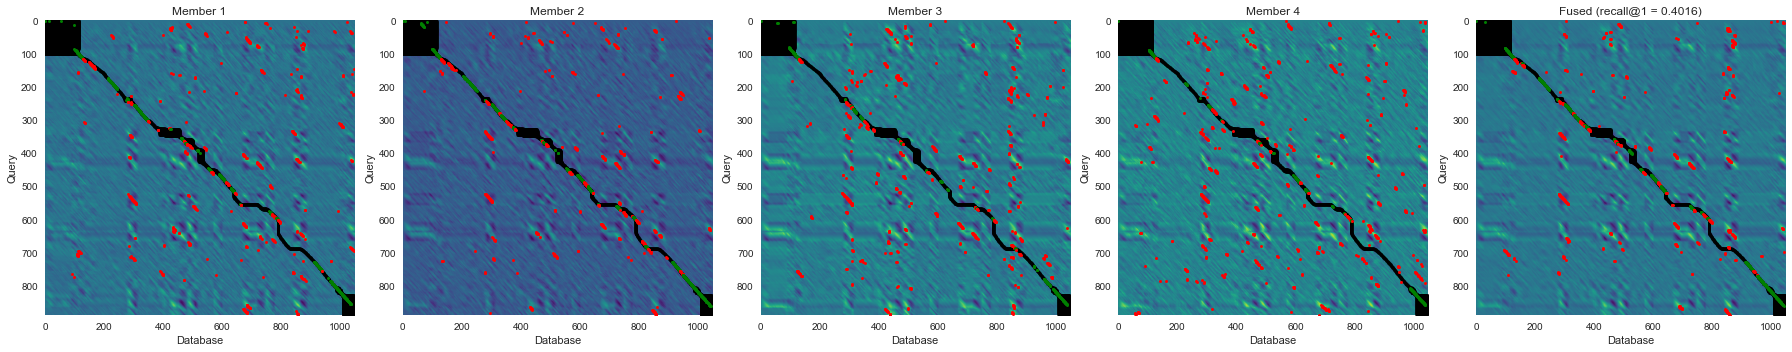


>>> Running ensemble for: R0_FN0 → R0_FS0 | over=recon
Ensembling for NSAVP (R0_FN0 vs R0_FS0), ensemble_over=recon, seqLen=30
Minimum rows: 910, Minimum cols: 890
Shape of combined similarity matrix: (910, 890)
Number of queries: 910



4 ensembles with recall@1: 0.3429 for NSAVP (R0_FN0 vs R0_FS0), ensemble_over=recon, seqLen=30
Shape of combined similarity matrix: (910, 890)
Number of queries: 910


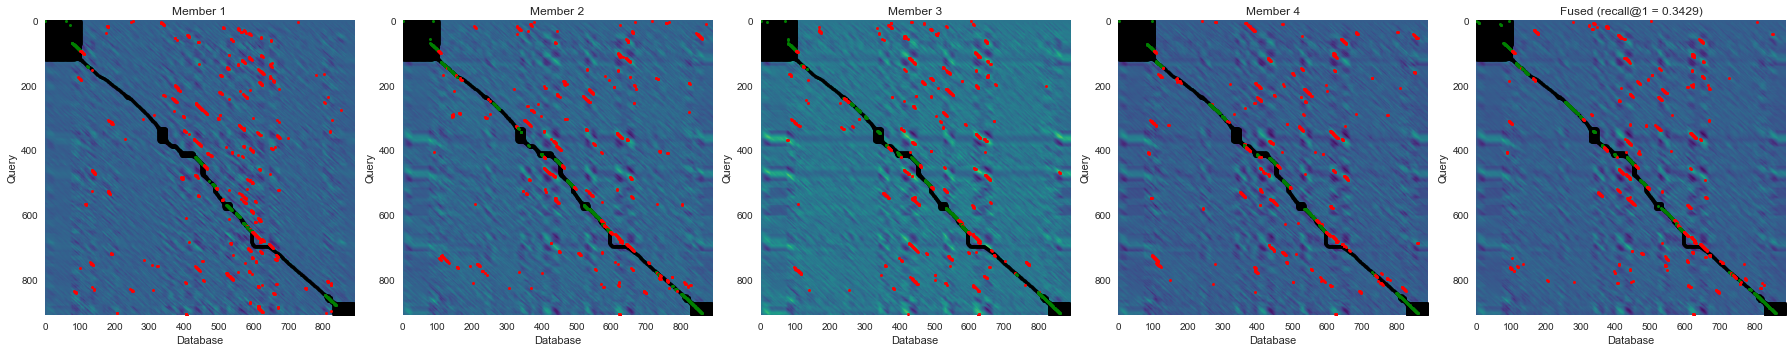


>>> Running ensemble for: R0_RA0 → R0_RN0 | over=recon
Ensembling for NSAVP (R0_RA0 vs R0_RN0), ensemble_over=recon, seqLen=30
Minimum rows: 932, Minimum cols: 1288
Shape of combined similarity matrix: (932, 1288)
Number of queries: 932



4 ensembles with recall@1: 0.3391 for NSAVP (R0_RA0 vs R0_RN0), ensemble_over=recon, seqLen=30
Shape of combined similarity matrix: (932, 1288)
Number of queries: 932


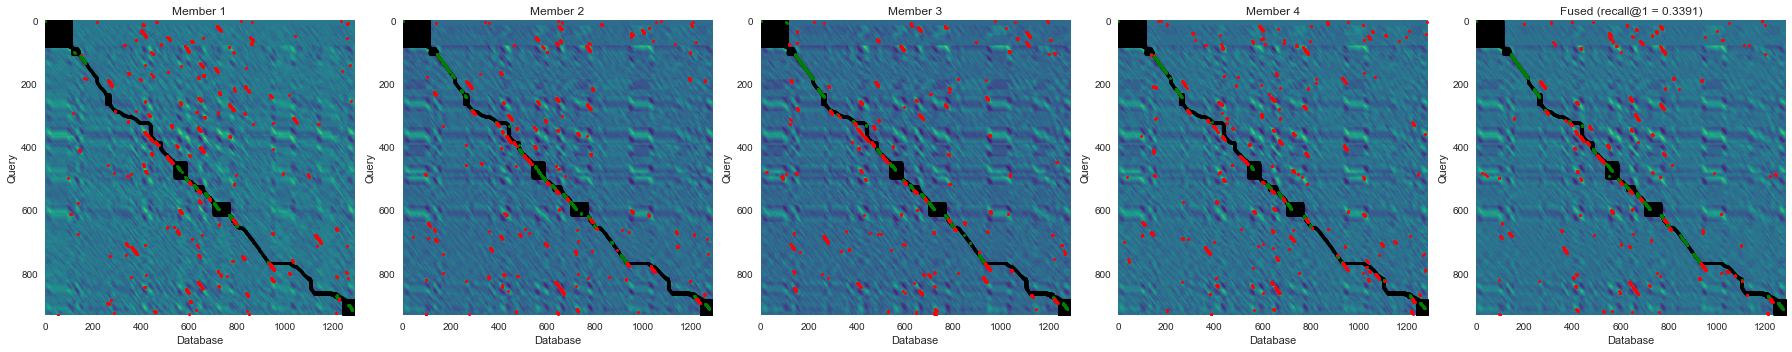


>>> Running ensemble for: R0_RS0 → R0_RN0 | over=vpr
Ensembling for NSAVP (R0_RS0 vs R0_RN0), ensemble_over=vpr, seqLen=30
Minimum rows: 932, Minimum cols: 1027
Shape of combined similarity matrix: (932, 1027)
Number of queries: 932



4 ensembles with recall@1: 0.3476 for NSAVP (R0_RS0 vs R0_RN0), ensemble_over=vpr, seqLen=30
Shape of combined similarity matrix: (932, 1027)
Number of queries: 932


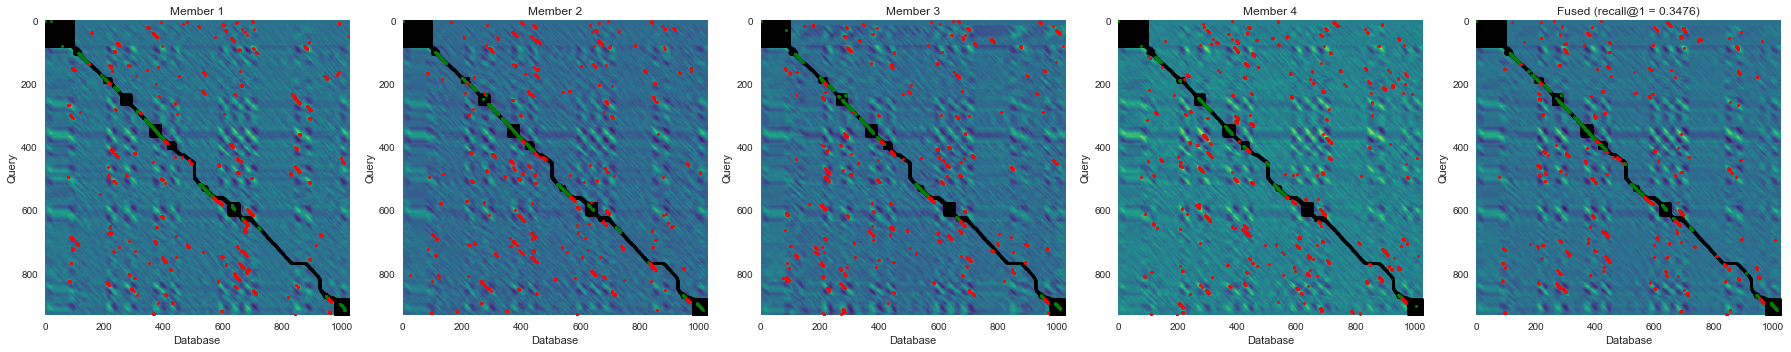


>>> Running ensemble for: sunset1 → night | over=time
Ensembling for Brisbane (sunset1 vs night), ensemble_over=time, seqLen=30
Minimum rows: 595, Minimum cols: 639
Shape of combined similarity matrix: (595, 639)
Number of queries: 595



4 ensembles with recall@1: 0.7496 for Brisbane (sunset1 vs night), ensemble_over=time, seqLen=30
Shape of combined similarity matrix: (595, 639)
Number of queries: 595


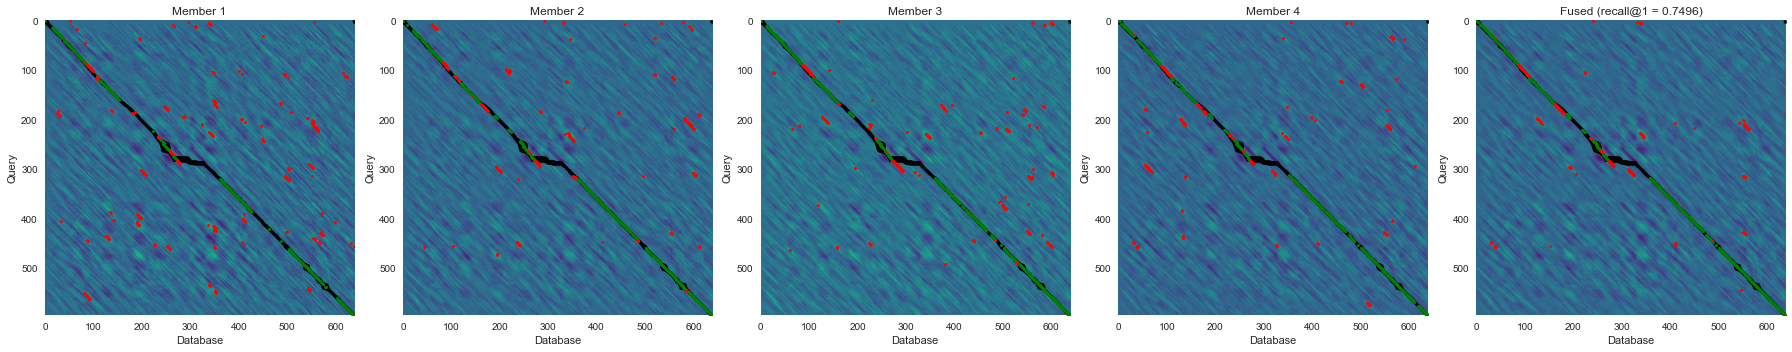


>>> Running ensemble for: R0_FA0 → R0_FS0 | over=vpr
Ensembling for NSAVP (R0_FA0 vs R0_FS0), ensemble_over=vpr, seqLen=30
Minimum rows: 910, Minimum cols: 1048
Shape of combined similarity matrix: (910, 1048)
Number of queries: 910



4 ensembles with recall@1: 0.5044 for NSAVP (R0_FA0 vs R0_FS0), ensemble_over=vpr, seqLen=30
Shape of combined similarity matrix: (910, 1048)
Number of queries: 910


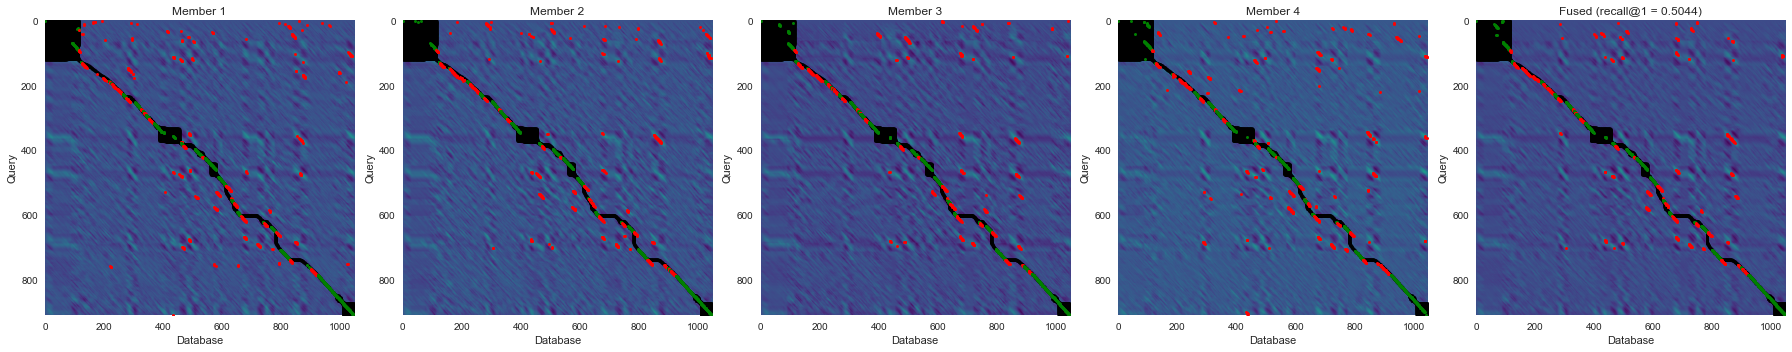


>>> Running ensemble for: sunset1 → daytime | over=patch
Ensembling for Brisbane (sunset1 vs daytime), ensemble_over=patch, seqLen=30
[!] Error running ensemble for sunset1 → daytime: local variable 'time_str' referenced before assignment

>>> Running ensemble for: sunset1 → morning | over=patch
Ensembling for Brisbane (sunset1 vs morning), ensemble_over=patch, seqLen=30
[!] Error running ensemble for sunset1 → morning: local variable 'time_str' referenced before assignment

>>> Running ensemble for: sunset1 → sunrise | over=patch
Ensembling for Brisbane (sunset1 vs sunrise), ensemble_over=patch, seqLen=30
[!] Error running ensemble for sunset1 → sunrise: local variable 'time_str' referenced before assignment

>>> Running ensemble for: sunset1 → sunset2 | over=patch
Ensembling for Brisbane (sunset1 vs sunset2), ensemble_over=patch, seqLen=30
[!] Error running ensemble for sunset1 → sunset2: local variable 'time_str' referenced before assignment


[]

In [ ]:
# best combo for each ref-qry pair and visualise similarity matrices

def run_ensemble_for_best_entries(best_entries_df):
    """
    Run the general_ensemble function for each best ref→qry pair in the given DataFrame.
    
    Parameters:
        best_entries_df: DataFrame containing best entries (e.g. from night_df groupby max recall@1)
        dataset_name: name of the dataset (e.g. 'Brisbane')
        ensemble_fn: the ensemble function to use (e.g. general_ensemble or optimize_general_ensemble)
    
    Returns:
        results: list of dicts containing ref_name, qry_name, fused recall, etc.
    """
    results = []

    for _, row in best_entries_df.iterrows():
        ref_name = row["ref_name"]
        qry_name = row["qry_name"]
        ensemble_over = row["ensemble_over"]

        # Convert strings like 'mixvpr,megaloc' to lists
        vpr_methods = row["vpr_methods"].split(',') if 'vpr' in ensemble_over else [row["vpr_methods"]]
        recon_methods = row["recon_methods"].split(',') if 'recon' in ensemble_over else [row["recon_methods"]]
        time_strs = [float(x) for x in row["time_strs"].split(',')] if 'time' in ensemble_over else [float(row["time_strs"])]
        seqLen = int(row["seqLen"])

        print(f"\n>>> Running ensemble for: {ref_name} → {qry_name} | over={ensemble_over}")

        try:
            general_ensemble(
                ref_name=ref_name,
                qry_name=qry_name,
                vpr_methods=vpr_methods,
                recon_methods=recon_methods,
                time_strs=time_strs,
                ensemble_over=ensemble_over,
                seqLen=seqLen
            )
        except Exception as e:
            print(f"[!] Error running ensemble for {ref_name} → {qry_name}: {e}")

    return results

best_day, best_night=print_day_night_summary(df)
run_ensemble_for_best_entries(best_night)
run_ensemble_for_best_entries(best_day )